# Zagadnienie testowe - prognoza 96 kroków

## Opis problemu

Zgodnie z opisem dostarczonym wraz z zestawem danych:
>**2.1	Opis zagadnienia**

>Przedmiotem zadania jest zaplanowanie i przeprowadzenie eksperymentu Machine Learning, wynikiem którego jest prognoza wartości szeregu czasowego na 96 kroków do przodu. Szereg czasowy jest zapisany w postaci pliku CSV w kolumnie VAR. Przedstawione pozostałe cechy to w większości dane pogodowe. Obserwacje były prowadzone przez cały rok w okresie co 15 min. Na potrzeby eksperymentu należy przyjąć, że prognoza zaczyna się dnia 2017-04-24 od godziny 00:00:00. Od tego momentu dysponujemy wszystkimi danymi oprócz prognozowanej zmiennej VAR (w rzeczywistości może to być prognoza pogody, tutaj są to rzeczywiste pomiary). 
>Do eksperymentu można wykorzystać wszystkie cechy lub tylko ich część. Do prognozy można wykorzystać historyczne wartość zmiennej VAR. 

>**2.2	Opis wyniku**

>Wynik proszę zapisać w postaci pliku. Może to być zarówno wektor wartości oddzielony separatorem lub plik ‘timeseries.csv’ zawierający uzupełnione wartości począwszy o daty „2017-04-24 00:00:00”. Prezentacja powinna zawierać opis przekształcania danych, opis metody, Wyznaczone parametry modelu: RMSE, MAE, R^2, wyniki prognozy oraz wnioski.


## Importowanie Bibliotek

In [1]:
# narzędzia ogólne
import pdb
import sys
from datetime import datetime

# wizualizacja danych
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('seaborn')

# przetwarzanie i analiza danych
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# architektura NN
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam, rmsprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# do modelu benchmarkowego
from fbprophet import Prophet

Using TensorFlow backend.


## Importowanie Danych

Dane analizować będziemy przy pomocy `Pandas`. Przejrzyjmy się kilku pierwszym obserwacjom:

In [2]:
df = pd.read_csv('timeseries.csv', index_col=0); df.head()

,Date,VAR,dewpti,hum,pressurei,rain,tempi,thunder,Day,Holiday,PCA_1
DateIdx,,,,,,,,,,,
2016-05-01 00:00:00,2016-05-01 00:00:00,24.25751,62.30,82.000000,29.960000,0.0,67.500000,0.0,1,0,-15.419709
2016-05-01 00:15:00,2016-05-01 00:15:00,25.38191,49.85,84.458356,29.832557,0.0,67.257999,0.0,1,0,198.166945
2016-05-01 00:30:00,2016-05-01 00:30:00,25.10542,62.60,88.000000,29.950000,0.0,66.200000,0.0,1,0,104.502454
2016-05-01 00:45:00,2016-05-01 00:45:00,24.22065,62.45,85.750000,29.950000,0.0,66.400000,0.0,1,0,119.514737
2016-05-01 01:00:00,2016-05-01 01:00:00,24.18378,62.30,83.500000,29.950000,0.0,66.600000,0.0,1,0,134.532242


Spójrzmy na podstawowe statystyki dotyczące danych:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 2016-05-01 00:00:00 to 2017-04-30 23:45:00
Data columns (total 11 columns):
Date         35040 non-null object
VAR          34368 non-null float64
dewpti       35040 non-null float64
hum          35040 non-null float64
pressurei    35040 non-null float64
rain         35040 non-null float64
tempi        35040 non-null float64
thunder      35040 non-null float64
Day          35040 non-null int64
Holiday      35040 non-null int64
PCA_1        35040 non-null float64
dtypes: float64(8), int64(2), object(1)
memory usage: 3.2+ MB


In [4]:
df.describe(include='all')

,Date,VAR,dewpti,hum,pressurei,rain,tempi,thunder,Day,Holiday,PCA_1
count,35040,34368.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,3.504000e+04
unique,35040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-11-20 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,24.551156,52.720154,61.963899,29.979410,0.076163,66.614993,0.003289,0.287671,0.038356,8.852665e-14
std,NaN,3.791351,11.685180,20.013889,0.290099,0.234463,9.309765,0.050211,0.452683,0.192057,1.059859e+02
min,NaN,15.005900,8.800000,6.000000,0.000000,0.000000,42.400000,0.000000,0.000000,0.000000,-1.957965e+02
25%,NaN,21.842820,43.550000,47.750000,29.840000,0.000000,60.400000,0.000000,0.000000,0.000000,-9.377721e+01
50%,NaN,24.344490,53.800000,63.250000,29.985000,0.000000,66.600000,0.000000,0.000000,0.000000,4.146117e+00
75%,NaN,26.856530,62.450000,78.000000,30.120000,0.000000,72.700000,0.000000,1.000000,0.000000,9.444932e+01


Na pierwszy rzut oka wydaje się, że w naszym zestawie występuje mieszanina rodzajów danych:
* data: `Date`
* dane ciągłe: `dewpti`, `hum`, `pressurei`, `tempi`, `PCA_1` i zmienna decyzyjna `VAR`
* dane dyskretne / binarne: `rain`, `thunder`, `Day`, `Holiday` 

Zmienne `rain` oraz `thunder` zostały zaimportowane w formacie `float` - jednak przy niskiej kardynalności w stosunku do ilości rekordów w naszej bazie, można by je w zasadzie uznać za zmienne dyskretne:

In [5]:
for col in ['rain', 'thunder']:
    print("="*25, col.upper(), "="*25)
    display(df[col].unique())
    print(len(df[col].unique()), "unikatowych wartości")
    print()

========================= RAIN =========================


array([0.        , 0.5       , 1.        , 0.75      , 0.25      ,
       0.375     , 0.125     , 0.625     , 0.875     , 0.83333333,
       0.66666667])

11 unikatowych wartości

========================= THUNDER =========================


array([0.   , 0.25 , 0.5  , 1.   , 0.75 , 0.125, 0.375])

7 unikatowych wartości



Pole `Date` zostało zaimportowane w formacie string. Będziemy chcieli wyciągnąć z niego jak najwięcej informacji, które pomogą nam wnioskować o obecności sezonowości w danych. Aby ułatwić sobie zadanie, przekonwertujemy dane na format *datetime*:

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d %H:%M'); df['Date'].describe()

count                   35040
unique                  35040
top       2017-04-19 18:30:00
freq                        1
first     2016-05-01 00:00:00
last      2017-04-30 23:45:00
Name: Date, dtype: object

Teraz wybierzemy cechy do ekstrakcji z pola daty. Zakres naszych danych to pełen rok. To powinno pozwolić nam wnioskować o obecności sezonowości rocznej - wyciągniemy więc dane o miesiącu i tygodniu. 

Na tym etapie kiedy mało jeszcze wiemy na temat danych nie możemy też wykluczyć specyficznych wahań związanych z częścią miesiąca, tygodnia i dnia, dlatego też dodatkowo wyciągniemy dane odpowiednio o dniu miesiąca, dniu tygodnia i godzinie dnia.

Przed ekstrakcją przemianujemy zmienną `Day` na `is_day` aby uniknąć konfliktu w nazewnictwie:

In [7]:
df['is_day'] = df['Day']

Ekstrakcja cech z pola daty:

In [11]:
attr = ['month', 'week', 'day', 'weekday', 'hour']

for a in attr: df[a.capitalize()] = getattr(df['Date'].dt, a)

In [12]:
df[[a.capitalize() for a in attr]].describe(include='all')

,Month,Week,Day,Weekday,Hour
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,6.526027,26.473973,15.720548,3.008219,11.500000
std,3.447901,14.996195,8.796373,2.003433,6.922285
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,4.000000,14.000000,8.000000,1.000000,5.750000
50%,7.000000,26.000000,16.000000,3.000000,11.500000
75%,10.000000,39.000000,23.000000,5.000000,17.250000
max,12.000000,52.000000,31.000000,6.000000,23.000000


Sprawdźmy teraz dane pod kątem brakujących wartości:

In [13]:
df.isna().sum()

Date           0
VAR          672
dewpti         0
hum            0
pressurei      0
rain           0
tempi          0
thunder        0
Day            0
Holiday        0
PCA_1          0
is_day         0
Month          0
Week           0
Weekday        0
Hour           0
dtype: int64

Danych brakuje tylko i wyłącznie w kolumnie `VAR` - najprawdopodobniej są to te brakujące obserwacje, które będziemy prognozować. Upewnijmy się, że tak jest.

Po pierwsze, sprawdźmy jaka jest ostatnia data dostępna w zestawie danych po odrzuceniu wszystkich wierszy z brakującymi danymi:

In [14]:
max_act = df.dropna()['Date'].max(); max_act

Timestamp('2017-04-23 23:45:00')

Teraz sprawdzimy czy w danych dostępnych do tej daty nie brakuje żadnych obserwacji:

In [15]:
dset = df[pd.to_datetime(df.index) <= max_act]
print(f'Dane przed {max_act} są {"kompletne" if dset.shape == dset.dropna().shape else "niekompletene"}')

Dane przed 2017-04-23 23:45:00 są kompletne


Pozostaje więc konkluzja, że wszystkie brakujące wartości znajdują się w okresie prognozowanym począwszy od 2017-04-24. Poniżej widzimy, że liczba obserwacji w okresie prognozowanym pokrywa się z liczbą brakujących obserwacji zmiennej `VAR`:

In [16]:
test_set = df[pd.to_datetime(df.index) > max_act]
test_set.shape[0], df['VAR'].isna().sum()

(672, 672)

672 kwadranse to pełen tydzień brakujących danych. Celem zadania jest co prawda prognoza na 96 kwadransów (1 dzień) do przodu i na tym się skupimy, tym niemniej stworzenie wiarygodnej prognozy dla wszystkich brakujących wartości potraktujemy jako cel dodatkowy.

## Analiza danych (EDA)

Czas zajrzeć głębiej w dane. W pierwszej kolejności spojrzymy na wykres zmiennej decyzyjnej `VAR`:

In [17]:
def time_series(name):
    plt.figure(figsize=(16,4))
    plt.title(name)
    pdf.plot()
    plt.show()

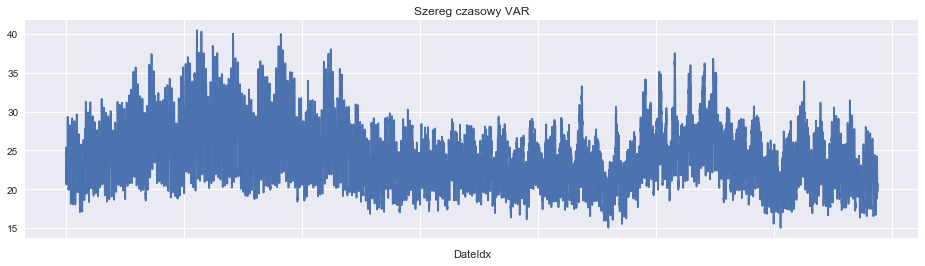

In [18]:
pdf = df['VAR'].dropna()
time_series('Szereg czasowy VAR')

Pierwsze wnioski:
* w tej skali wydaje się, że sygnał pomieszany jest relatywnie dużą ilością szumu
* widać też obecność długoterminowego trendu - być może związanego z sezonowością roczną

Aby uzyskać lepszy obraz sytuacji spojrzymy na następujące wykresy zmiennej `VAR`:
1. Średnie miesięczne
1. Średnie tygodniowe
1. Ostatnie 8 tygodni danych
1. Ostatnie 672 obserwacje

Zdefiniujmy sobie zatem pomocnicze zmienne `Year_Month` i `Year_Week`, które pomogą nam w agregacji wyników:

In [19]:
for col in ['Month', 'Week']:
    df[f'Year_{col}'] = list(map(str, (
        df['Date'].dt.year * 100 + eval(f"df['Date'].dt.{col.lower()}")
    ).values))

Wykresy:

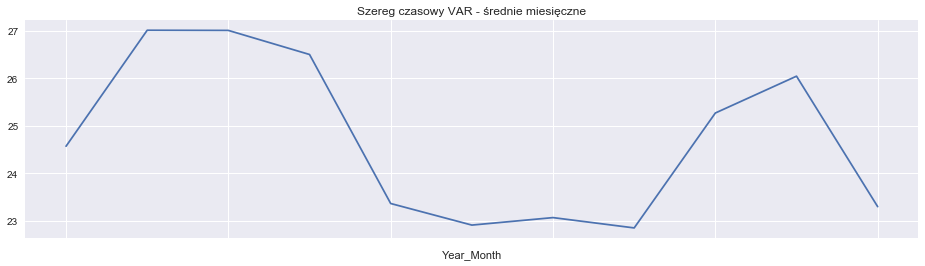

In [20]:
pdf = df[['Year_Month', 'VAR']].dropna().groupby('Year_Month').mean()['VAR'][:-1]
time_series('Szereg czasowy VAR - średnie miesięczne')

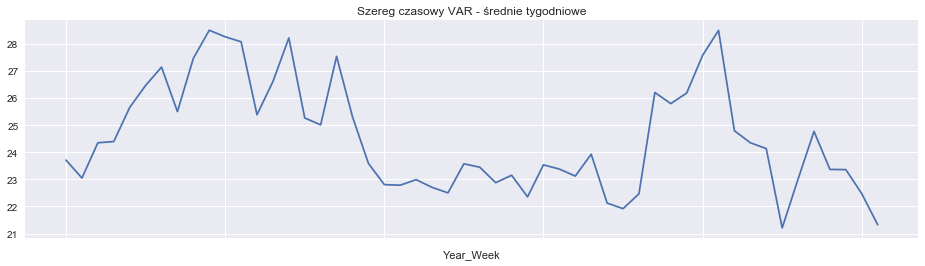

In [21]:
pdf = df[['Year_Week', 'VAR']].dropna().groupby('Year_Week').mean()['VAR'][:-1]
time_series('Szereg czasowy VAR - średnie tygodniowe')

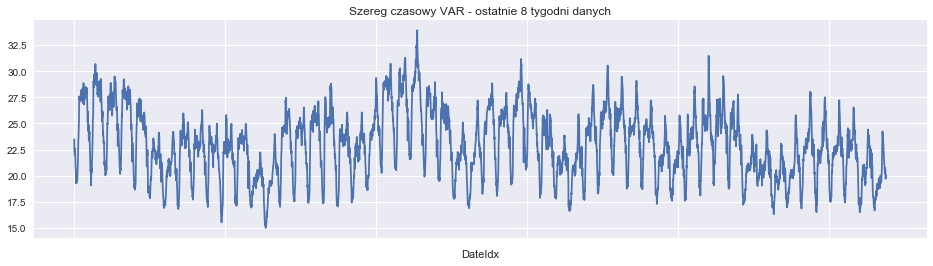

In [22]:
pdf = df['VAR'].dropna()[-672*8:]
time_series('Szereg czasowy VAR - ostatnie 8 tygodni danych')

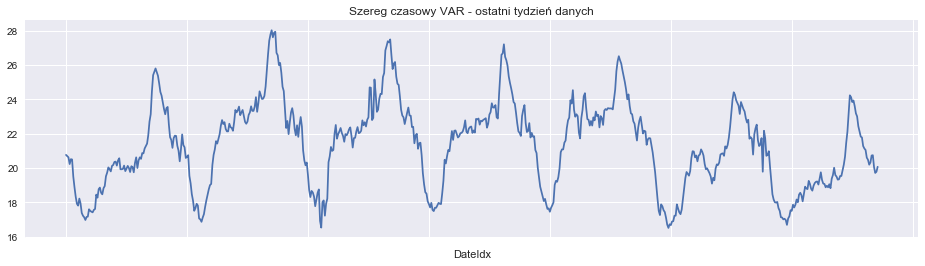

In [23]:
pdf = df['VAR'].dropna()[-672:]
time_series('Szereg czasowy VAR - ostatni tydzień danych')

Tendencje roczne w danych widać teraz wyraźniej. Ponadto nie da się wykluczyć sezonowości tygodniowej a spojrzenie na ostatni tydzień danych wskazuje na dość wyraźny cykl dobowy.

Dla jeszcze pełniejszego obrazu tendencji sezonowych spójrzmy więc na średnie wartości `VAR` dla kolejnych poziomów zmiennych sezonowych:

In [24]:
def plot2VAR(cols):
    for col in cols:
        pdf = df[[col, 'VAR']].groupby(col).agg(['mean'])
        pdf_v = pdf.values.reshape(-1,)
        plt.figure(figsize=(16, 5))
        plt.title(col)
        plt.fill_between(list(range(len(pdf_v))), pdf_v, alpha=0.5)
        plt.xticks(list(range(len(pdf.index))), pdf.index)
        plt.xlabel('')
        rang = range(len(pdf))
        plt.plot(list(rang), [df['VAR'].mean() for i in rang], color='r', linestyle=":", linewidth=3, label="Średnia VAR") 
        plt.legend()
    plt.show()

Średnia wartość VAR dla wybranych cech otrzymanych z pola 'Date':


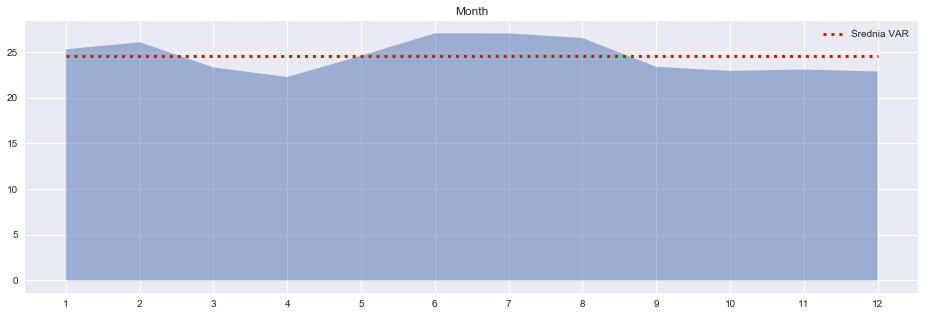

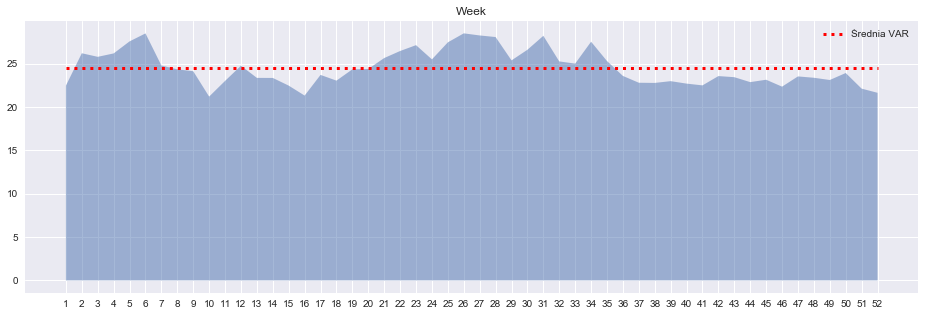

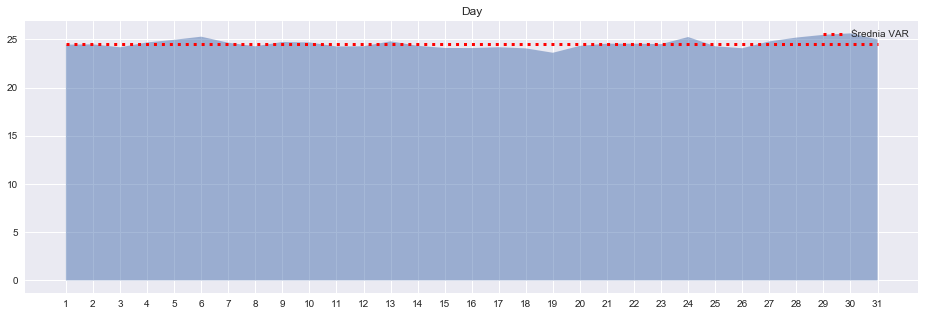

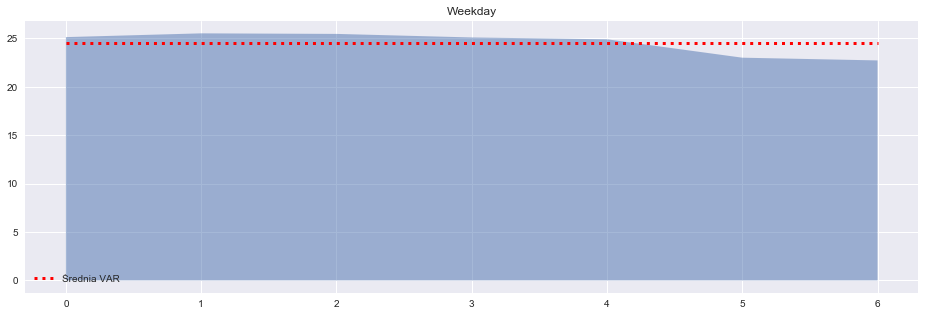

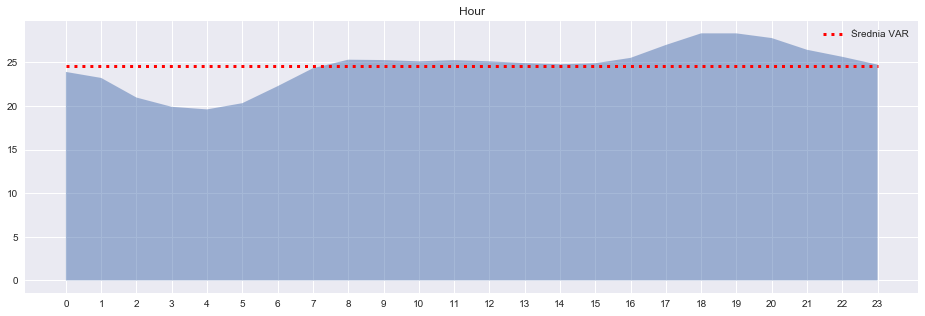

In [25]:
seasonal = ['Month', 'Week', 'Day', 'Weekday', 'Hour']
print("Średnia wartość VAR dla wybranych cech otrzymanych z pola 'Date':")
plot2VAR(seasonal)

Kolejne wnioski:

* odnośnie sezonowości rocznej: `Month` i `Week` wskazują, że najwyższe średnie wartości `VAR` odnotowujemy na początku roku oraz w miesiącach wakacyjnych
* nie widać wyraźnych tendencji związanych z porą miesiąca
* w ciągu tygodnia niższe wartości `VAR` obserwujemy w weekendy
* potwierdza się też teza o wyraźnej sezonowości dobowej: najwyższe średnie wartości dzienne `VAR` odnotowujemy dla godzin wieczornych, zaś najniższe między 2:00 a 5:00

Na podstawie dotychczasowych wniosków wydaje się, że `VAR` może być skorelowana na przykład ze zużyciem lub zapotrzebowaniem na energię.. :)

W podobny sposób przeanalizować możemy średnie wartości przyjmowane przez `VAR` dla zmiennych binarnych:

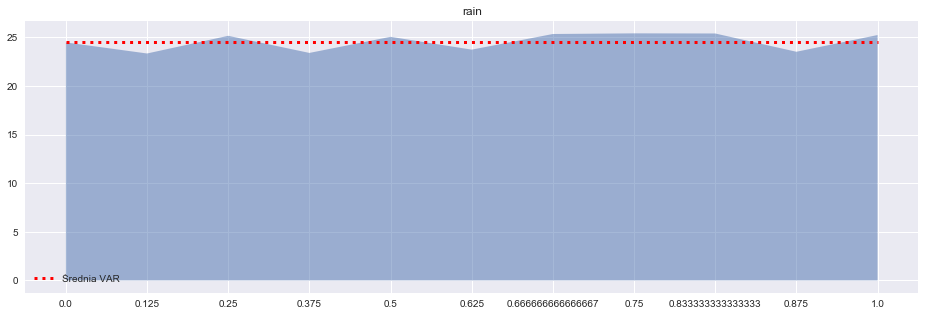

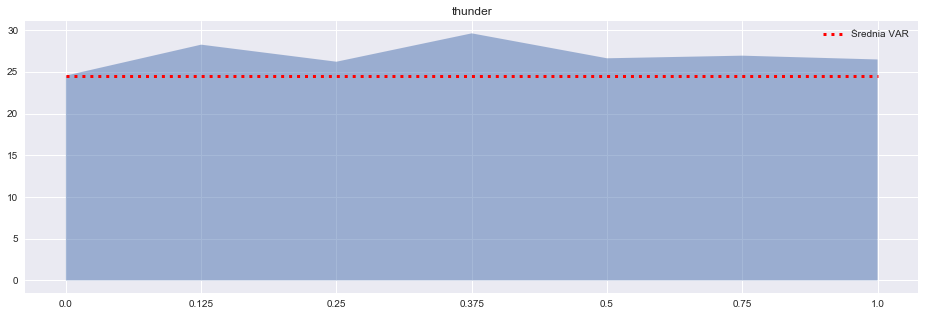

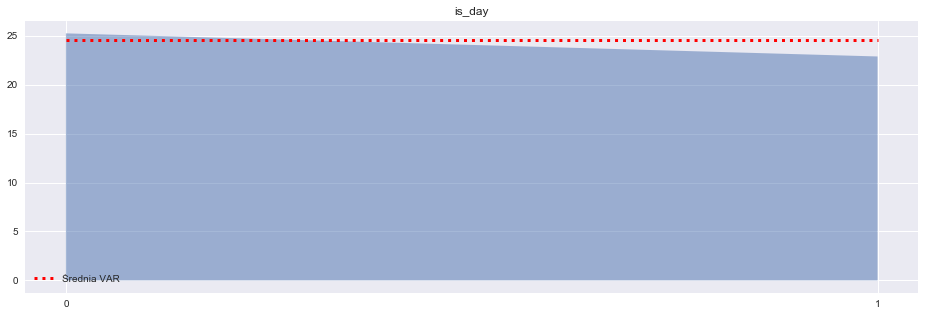

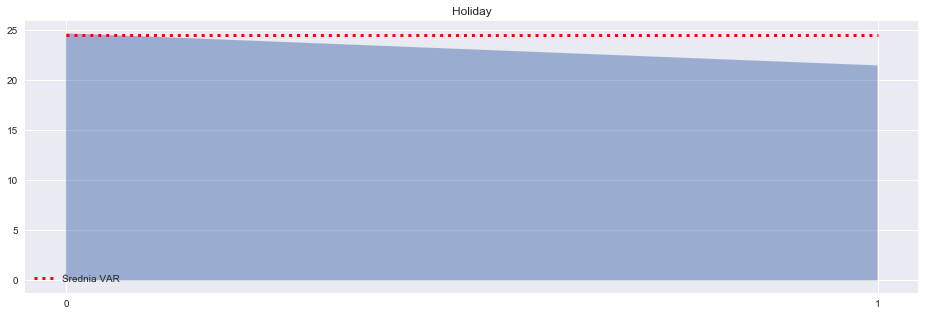

In [26]:
binary = ['rain', 'thunder', 'is_day', 'Holiday']
plot2VAR(binary)

Dla zmiennej `rain` trudno zaobserwować wyraźną tendencję. W przypadku pozostałych zmiennych możemy mieć natomiast do czynienia z jakąś zależnością. Należy tu jednak pamiętać, że w takim ujęciu nie widzimy liczebności poszczególnych klas zmiennych.

Kolejnym etapem będzie więc przeanalizowanie wykresów punktowych zmiennych niezależnych względem `VAR` - spojrzymy tu również na zmienne ciągłe:

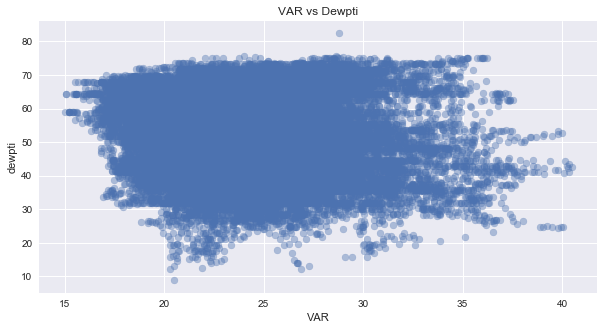

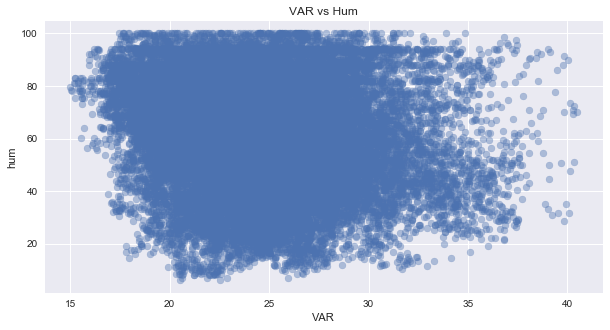

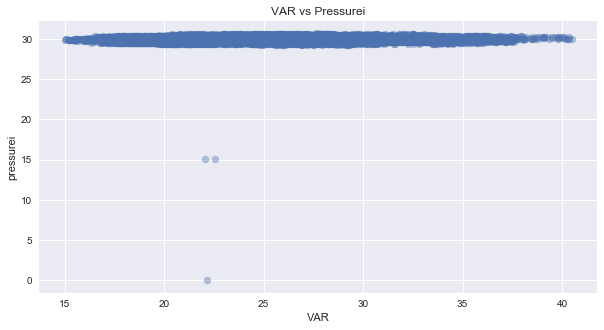

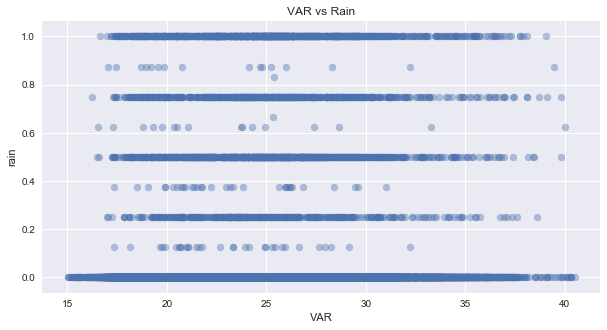

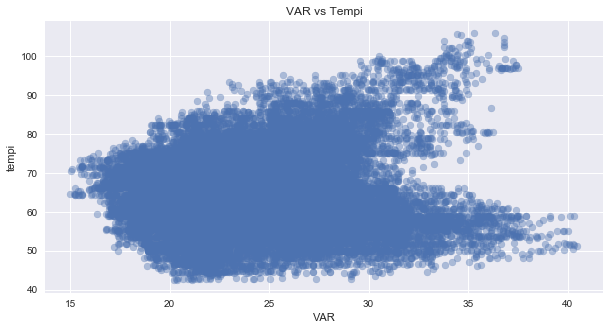

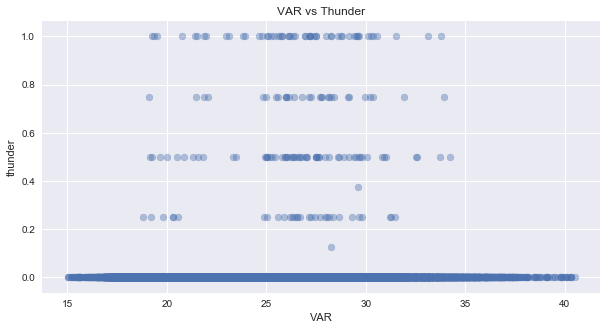

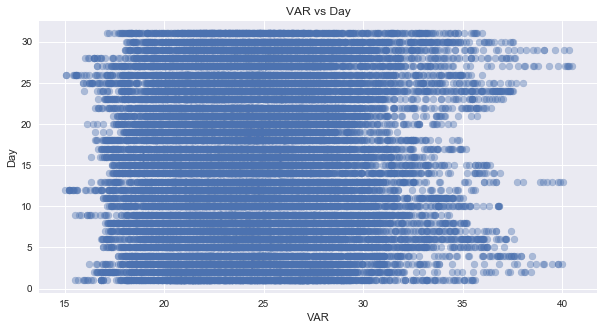

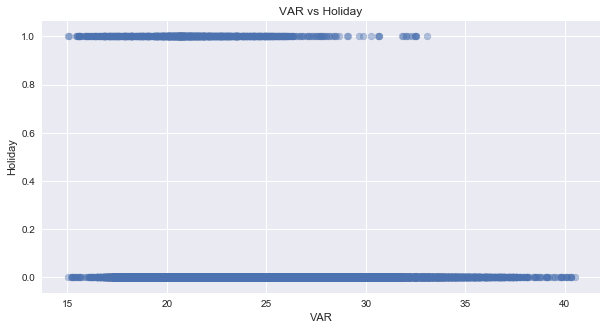

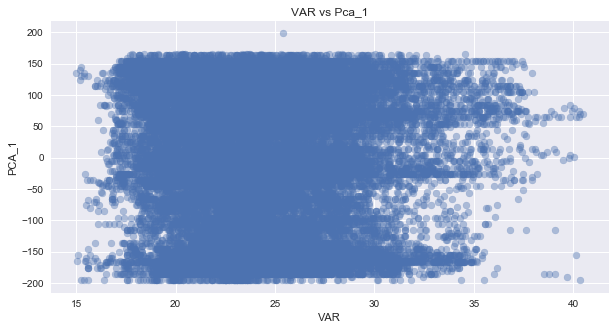

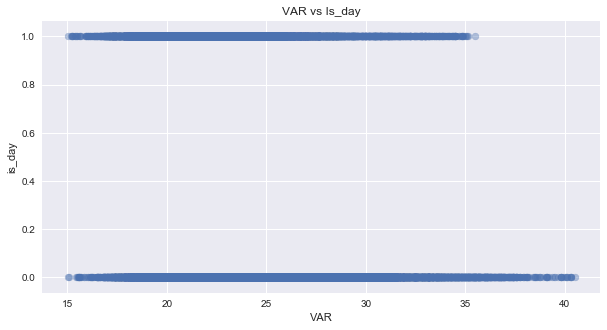

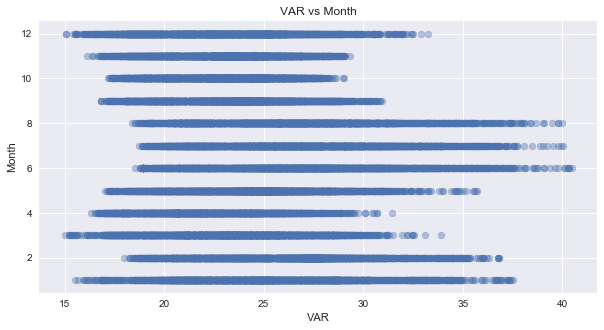

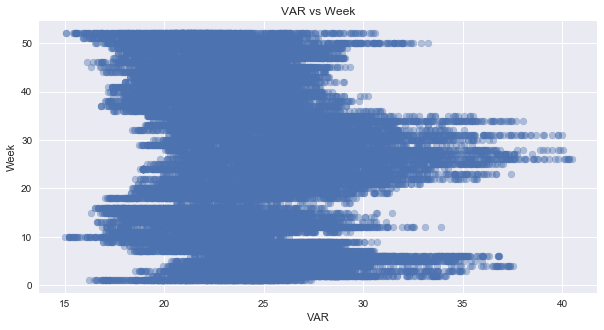

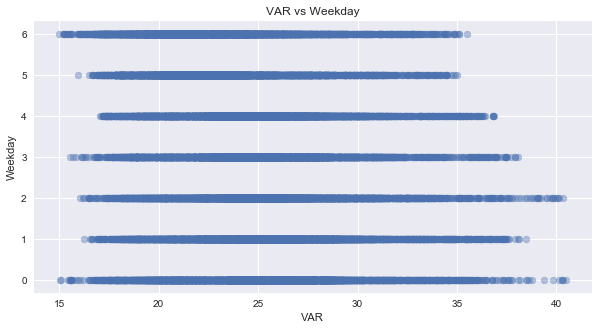

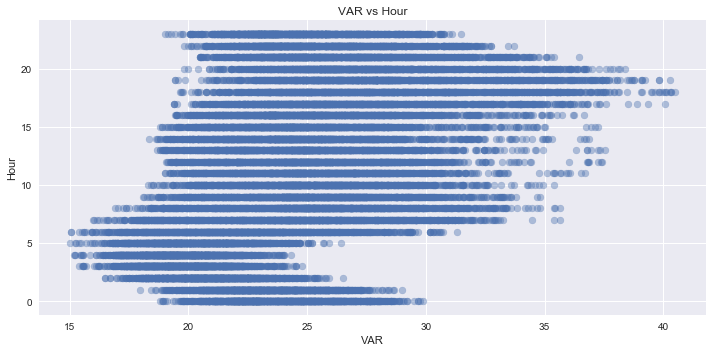

In [27]:
cols = df.drop(columns=['VAR', 'Date', 'Year_Month', 'Year_Week']).columns

for col in cols:
    plt.figure(figsize=(10, 5))
    plt.title(f'VAR vs {col.capitalize()}')
    plt.xlabel('VAR')
    plt.ylabel(col)
    plt.scatter(df['VAR'], df[col], alpha=0.4)
plt.tight_layout()
plt.show()

Wnioski z powyższych wykresów:
* w zmiennej `pressurei` mamy do czynienia z wartościami odstającymi zaburzającymi obraz zależności - przyjrzymy się temu dokładniej niebawem
* zmienna `tempi` wydaje się przejawiać jakąś formę nieliniowej zależności od `VAR`: zmienna zależna osiąga najwyższe wartości dla bardzo niskich i bardzo wysokich wartości `tempi`; to może być kolejne potwierdzenie tezy o zależności `VAR` od zużycia energii - byłoby ono wyższe w sezonie grzewczym jak i w gorące lato w związku z działaniem klimatyzatorów; warto zauważyć, że zmienna `Month` wykazuje już bardzo podobne zależności
* potwierdzają się wcześniejsze obserwacje o tendencjach sezonowych (zwłaszcza dobowych i tygodniowych) oraz dla zmiennych `Holiday` i `is_day`
* w przypadku pozostałych zmiennych ciężko wyciągnąć jednoznaczne konkluzje

Następnym etapem będzie analiza szeregów czasowych zmiennych ciągłych w kontekście ich średniej i zakresu wyznaczonego przez odchylenie standardowe:

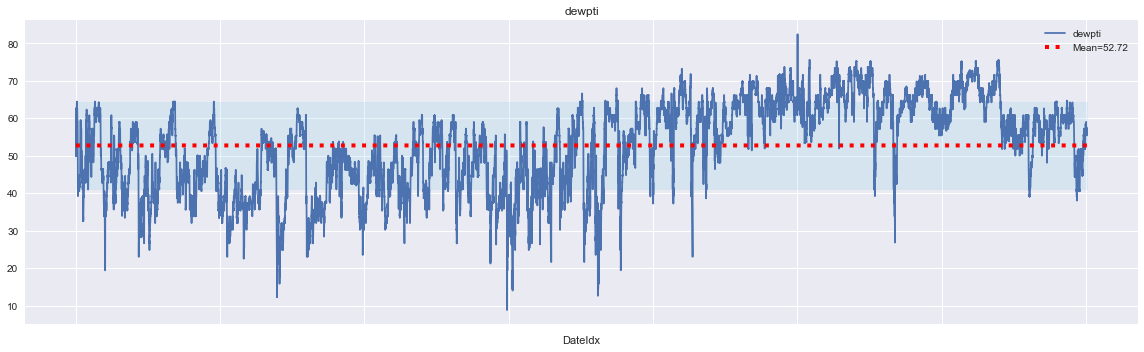

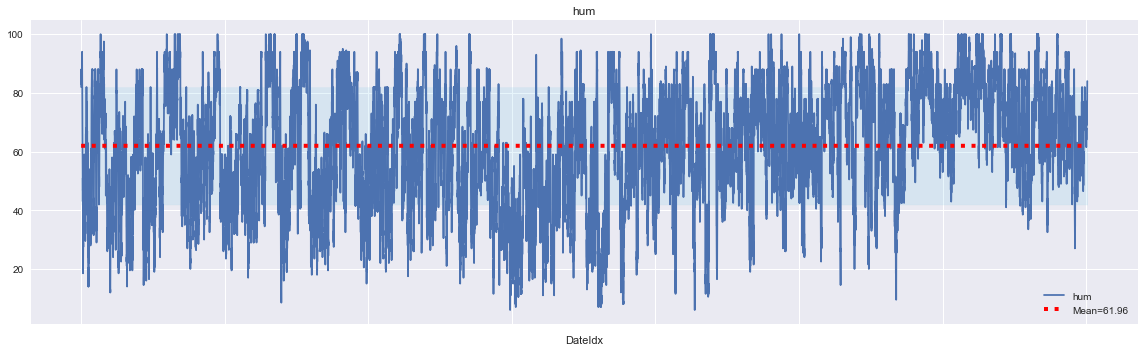

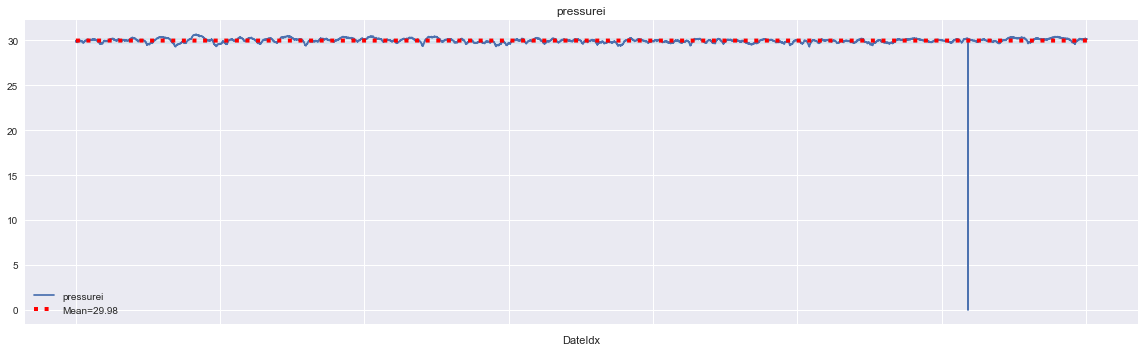

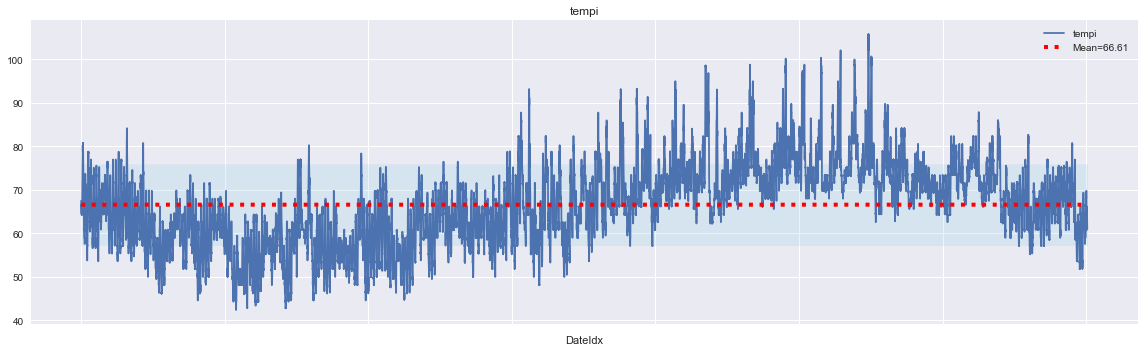

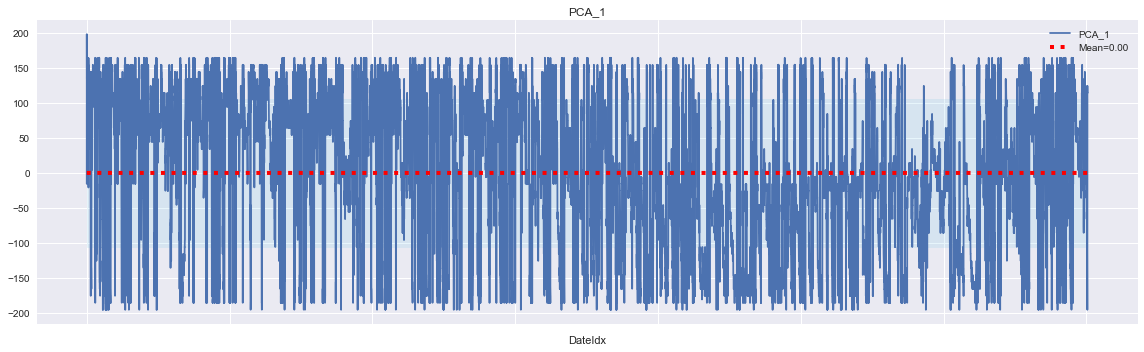

In [28]:
for col in ['dewpti', 'hum', 'pressurei', 'tempi', 'PCA_1']:
    plt.figure(figsize=(16,5))
    plt.title(col)
    df[col].plot()
    m = df[col].mean()
    s = df[col].std()
    plt.fill_between(list(range(len(df))), y1=m+s, y2=m-s, color='skyblue', alpha=0.2)
    plt.plot([m]*len(df), color='r', linestyle=':', linewidth=4, label=f'Mean={m:.2f}')
    plt.legend()
    plt.tight_layout()
plt.show()

Zmienne pogodowe wykazują się brakiem stacjonarności - co nie jest niespodzianką, gdyż warunki pogodowe mają przeważnie tendencje sezonowe.

Ciężej wysnuć wniosek w przypadku zmiennej `PCA_1`, którą wyraźnie cechuje duża ilość szumu. Spojrzymy więc na jej średnie tygodniowe:

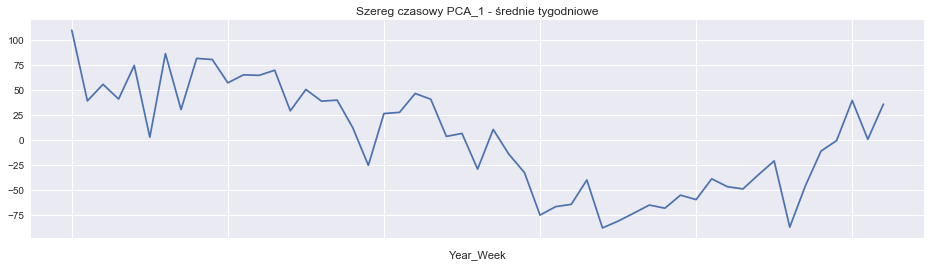

In [29]:
pdf = df[['Year_Week', 'PCA_1']].groupby('Year_Week').mean()['PCA_1'][:-1]
time_series('Szereg czasowy PCA_1 - średnie tygodniowe')

Tu wyraźnie widzimy trend obecny w danych - ta zmienna również jest niestacjonarna.

Poprzedni zestaw wykresów raz kolejny ukazał też wartość silnie odstającą w szeregu `pressurei` - czas przyjrzeć się temu bliżej:

In [30]:
df['pressurei'].describe()

count    35040.000000
mean        29.979410
std          0.290099
min          0.000000
25%         29.840000
50%         29.985000
75%         30.120000
max         30.690000
Name: pressurei, dtype: float64

In [31]:
df['pressurei'].sort_values()[:10]

DateIdx
2017-03-19 00:30:00     0.0000
2017-03-19 00:45:00    15.0825
2017-03-19 00:15:00    15.0925
2016-06-05 23:45:00    29.3000
2017-01-20 16:30:00    29.3000
2017-01-20 18:30:00    29.3000
2016-06-06 00:30:00    29.3000
2016-06-06 00:15:00    29.3000
2016-06-06 00:00:00    29.3000
2016-06-05 23:30:00    29.3000
Name: pressurei, dtype: float64

Wartość `pressurei` spadła do zera tylko raz w analizowanym okresie (przyjmując wartość ~15 kwadrans przed i po tym wydarzeniu), w pozostałych przypadkach wahała się w przedziale 29.3-30.7. Jest to silny sygnał, że mamy tu do czynienia z problemem dotyczącym jakości danych - być może usterką ciśnieniomierza. 

Bez możliwości sprawdzenia u źródła podejmiemy na tym etapie decyzję o korekcie danych aby zminimalizować wpływ tego odchylenia na proces uczenia modelu. Aby nie naruszyć pozostałych danych, próg ucięcia ustawimy jako trzy wielokrotności odchylenia standardowego:

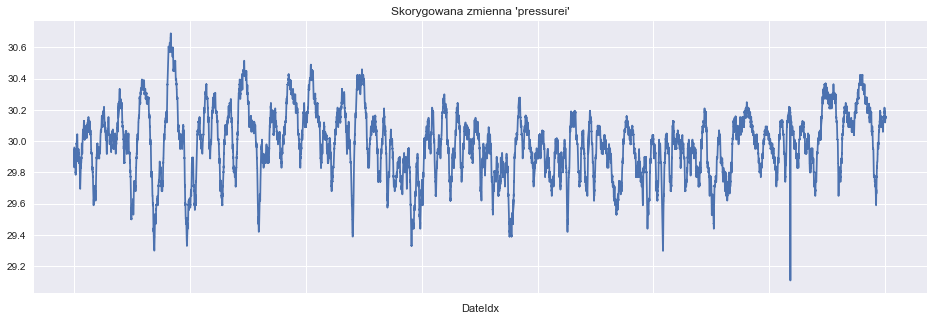

In [32]:
m = df['pressurei'].mean()
s = df['pressurei'].std()
df['pressurei'].clip(lower=m-3*s).plot(figsize=(16,5), title="Skorygowana zmienna 'pressurei'")
plt.show()

Obserwacja wciąż odstaje od reszty, ale jej wpływ nie będzie już tak ekstremalny. Dokonujemy korekty danych:

In [33]:
df['pressurei'].clip(lower=m-3*s, inplace=True)

Rzućmy teraz okiem na korelogram Pearsona zmiennych niezależnych względem zmiennej `VAR`:

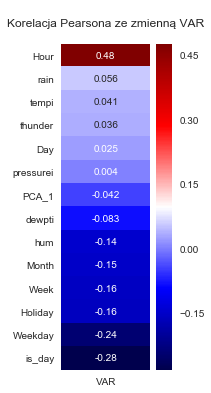

In [35]:
plt.figure(figsize=(2, 6))
plt.title('\nKorelacja Pearsona ze zmienną VAR\n')
sns.heatmap(df.corr()['VAR'].to_frame()[1:].sort_values(by='VAR', ascending=False), annot=True, cmap='seismic')
plt.show()

Wyniki wskazują na istotne zależności liniowe z niekrótymi zmiennymi, w szczególności `Hour`, `Weekday` i `is_day`. Musimy jednak zachować ostrożność w interpretacji pamiętając, że:
* zmienne sezonowe mają obecnie formę indeksów co sprawia, że są nieadekwatne do analizy korelogramem - wrócimy do tego zagadnienia na etapie transformacji danych
* korelogram Pearsona nie jest w stanie uchwycić nieliniowych zależności - a te jak widzieliśmy wcześniej najprawdopodobniej występują w naszych danych
* niektóre zależności mogą występować w nieliniowych kombinacjach cech - tego również nie zobaczymy w korelogramie

Uwzględniając te wątpliwości wydaje się, że potencjalnie ciekawsze wnioski mogą wypłynąć przy analizie pełnego korelogramu naszych danych:

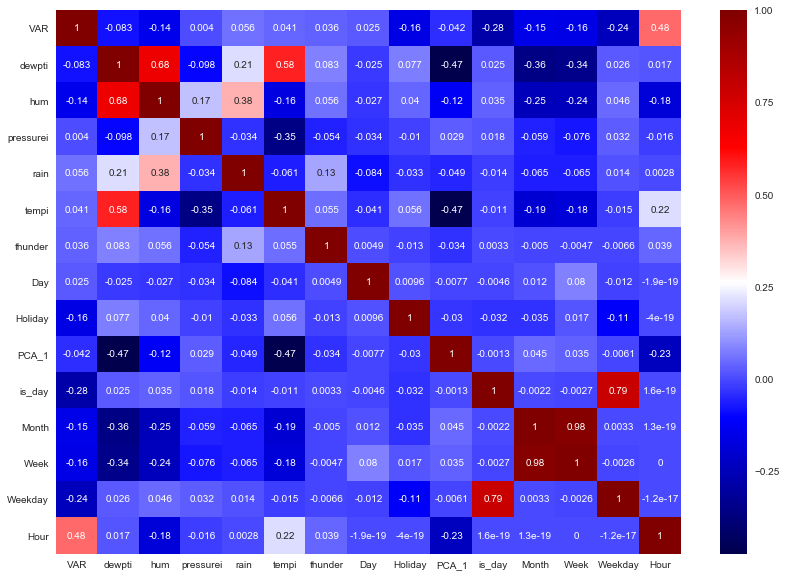

In [36]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, cmap='seismic')
plt.show()

Wnioski:
* cechy związane z pogodą wydają się być między sobą relatywnie silnie zależne liniowo - co znów nie jest zaskakujące mając na uwadze naturę zjawisk pogodowych
* widzimy też silną korelację pomiędzy `PCA_1` a `hum` i `tempi` - być może jest to cecha utworzona przy pomocy analizy PCA na tych cechach
* silnie skorelowane są również `Weekday` i `is_day` - spójrzmy na ich wykres punktowy:

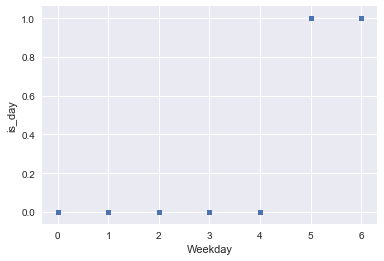

In [39]:
df[['Weekday', 'is_day']].plot.scatter('Weekday', 'is_day')
plt.show()

Innymi słowy zmienna `is_day` to tak naprawdę wkaźnik mówiący czy jest weekend. Tę funkcję w jakimś stopniu spełnia nam już zmienna `Weekday` - może więc się okazać, że `is_day` będzie mniej istotna w modelu.

Wyposażeni w dotychczasowe wnioski, zastanowimy się teraz jak zmierzyć się z problemem modelowania.

## Modelowanie

Problem decyzyjny, przed którym jesteśmy postawieni w tym zadaniu to dokonać prognozy na 96 okresów (jeden pełen dzień) do przodu dla brakujących obserwacji zmiennej `VAR`, począwszy od północy 2017-04-24.

Jest kilka podejść znanych z klasycznej analizy szeregów czasowych, które moglibyśmy zastosować aby osiągnąć ten cel:
1. **Stworzenie modelu prognozującego jeden okres do przodu i wykorzystanie go w rekursywnym prognozowaniu dla 96 okresów**
 > *Zalety*:
  * wiele różnych klas modeli uczenia maszynowego daje możliwość prognozy na jeden okres do przodu (np. regresja liniowa czy regresje oparte na drzewach decyzyjnych)
  * to najprostsze w implementacji podejście
  
 > *Wady*:
  * jak pokazuje praktyka, takie modele rzadko radzą sobie z modelowaniem długoterminowych zależności obecnej w danych
  * rekursywna predykcja oznacza akumulację błędu prognozy - przy 96 kolejnych prognozach to może bardzo mocno skrzywić wyniki
  
1. **Opracowanie oddzielnych modeli dla każdej z 96 prognozowanych wartości**
 > *Zalety*:
  * błąd predycji nie akumuluje się w progozie
  
 > *Wady*:
  * potrzeba estymacji 96 oddzielnych modeli!
  * modele estymują każdy z okresów niezależnie od siebie a więc nie są w stanie uchwycić zależności pomiędzy kolejnymi elementami sekwencji
  
1. **Podejście hybrydowe: stworzenie oddzielnych modeli dla grupy przyszłych obserwacji i wykorzystanie ich do rekursywnej prognozy**
 > Wady i zalety będą podobne jak w pierwszych dwóch punktach, w zależności od tego na której z tych dwóch metod będziemy polegali bardziej
 
Istnieje jednak jeszcze inne możliwe podejście: **stworzenie modelu estymującego wszystkie 96 okresów na raz**. W ten sposób unikniemy wad wyżej wymienionych podejść. 

Aby to osiągnąć, potrzebujemy modelu, który na podstawie zadanej sekwencji danych utworzy wektor będący sekwencją prognoz. W modelowaniu sekwencji jako takich wielką popularność zyskały modele [*Recurrent Neural Network*](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNN), w szczególności modele wykorzystujące komórki [*Long-Short Term Memory*](https://en.wikipedia.org/wiki/Long_short-term_memory) (LSTM) - powszechnie nazywane modelami LSTM. 


![lstm](lstm.png)


W modelach LSTM tradycyjne neurony / perceptrony zastąpione są komórkami LSTM (*LSTM cell*) wyposażonymi w stan (pamięć) komórki oraz operacje, które pozwalają elastycznie modyfikować ten stan i włączać go częściowo lub w całości w proces obliczania wyniku w danym kroku czasowym (*timestep*). Dzięki temu przy zastosowaniu relatywnie płytszych architektur jesteśmy w stanie zapewnić modelowi długoterminową pamięć. Zastosowanie komórek LSTM pozwala też ograniczyć ryzyko wystąpienia tzw. [problemu znikającego gradientu](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) charakterystyczne dla głębokich sieci neuronowych - w szczególności sieci rekurencyjnych. 

Modele LSTM osiągnęły w ostatnich latach niespotykane wcześniej wyniki m.in. w obszarze *Natural Language Processing*. Jako że z natury operują na sekwencjach danych, znajdują również zastosowanie w analizie szeregów czasowych. Co istotne, pozwalają na jednoczesne generowanie całych sekwencji danych - dlatego też użyjemy modelu tej klasy aby zmierzyć się z naszym zadaniem.

Zanim jednak przejdziemy do samego modelowania, dokonamy pewnych transformacji w naszym zestawie danych aby umożliwić / ułatwić sobie zadanie.

### Przygotowanie danych do modelowania

Po pierwsze, zdefiniujemy zmienną będącą opóźnieniem zmiennej `VAR` o jeden okres (kwadrans) po to aby wykorzystać ją w procesie modelowania jako element autoregresyjny:

In [41]:
df['VAR_lag'] = df['VAR'].shift(1)

Po drugie, dokonamy transformacji zmiennych powiązanych z sezonowością, które obecnie reprezentowane są w danych jako kolejne w sekwencji wartości. Tak jak wspomnieliśmy wcześniej, podejrzewamy, że zależności między poszczególnymi wartościami tych zmiennych mogą być nieliniowe (np. widzieliśmy że `VAR` osiąga wyższe wartości dla stycznia-lutego a następnie w środku roku, ponadto siła oddziaływania poszczególnych miesięcy może być inna, itd.). Co prawda dzięki zastosowaniu odpowiedniej ilości nieliniowych warstw i neuronów / komórek, byłoby potencjalnie możliwe zrozumienie takich nieliniowych zależności przy zmiennych w dotychczasowej postaci.

Tym niemniej dostosowanie danych do natury problemu ułatwi i przyspieszy proces uczenia modelu. Zastosujemy tu podejście tzw. *one-hot encoding* (po polsku nazywane [*kodowaniem 1 z n*](https://pl.wikipedia.org/wiki/Kod_1_z_n)), tj. zamianę indeksów poszczególnych miesięcy / dni / godzin na wektory zero-jedynkowe. W ten sposób każda kategoria takiej zmiennej będzie widziana przez model jako niezależna zmienna - w efekcie pozwoli to łatwiej / szybciej zrozumieć w jaki sposób wpływają na zmienną zależną.

Na podstawie wniosków z wcześniejszej analizy danych, stworzymy wektory *one-hot* dla zmiennych `Month`, `Weekday` i `Hour`:

In [40]:
for col in ['Month', 'Weekday', 'Hour']: df = pd.concat((df, pd.get_dummies(df[col], prefix=col, drop_first=True)), axis=1)

Porównamy teraz wartości korelacji Pearsona z włączeniem nowo wygenerowanych zmiennych:

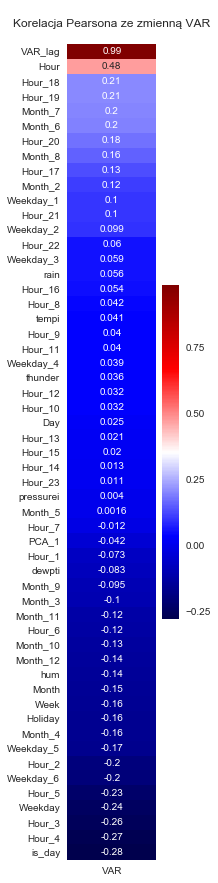

In [42]:
plt.figure(figsize=(2, 15))
plt.title('\nKorelacja Pearsona ze zmienną VAR\n')
sns.heatmap(df.corr()['VAR'].to_frame()[1:].sort_values(by='VAR', ascending=False), annot=True, cmap='seismic')
plt.show()

Obraz powiązania z indywidualnymi podkategoriami jest teraz pełniejszy - w szczególności w przypadku zmiennej `Month` gdzie podejrzewaliśmy zależność nieliniową. Nasz model powinien mieć teraz ułatwione zadanie!

**Proces Stacjonarny**

W czasie analizy danych widzieliśmy, że wiele zmiennych - w tym sama zmienna zależna - zawiera element trendu długoterminowego. W klasycznym modelowaniu szeregów czasowych stanowi to duży problem: niestacjonarność zmiennych sprawia, że wytrenowany model może być bezużyteczny w przewidywaniu przyszłych wartości, których rozkład będzie inny niż w danych treningowych.

Tu również czysto teoretycznie możliwe jest, że przy zastosowaniu odpowiednio dużej architektury i ilości danych, model LSTM byłby w stanie skutecznie uchwycić zależności w niestacjonarnym procesie. Transformacja danych do postaci stacjonarnej jednak ułatwi i przyspieszy proces uczenia - dlatego też zdecydujemy się na ten krok.

Jest wiele metod sprowadzania danych do postaci stacjonarnej. Z analizy danych wiemy, że nasze zmienne niestacjonarne - `VAR` (a więc również jej wartość opóźniona), `dewpti`, `hum`, `pressurei` i `tempi` - nie przyjmowały w żadnym momencie ujemnych wartości. Chcielibyśmy zachować te właściwość w naszej prognozie, dlatego też jako metodę transformacji do postaci stacjonarnej dla zmiennej decyzyjnej - i konsekwentnie również dla zmiennych pogodowych  - wybierzemy różnicę logarytmów naturalnych, zwaną też wzrostem logarytmowanym (*log growth*). Wartości uzyskane z tej transformacji można interpretować w taki sam sposób jak klasyczną stopę wzrostu - obie transformacje dają zresztą zbliżone rezultaty. Różnica logarytmów naturalnych natomiast nigdy nie osiągnie ujemnej wartości w prognozie.

Zdefiniujemy więc funkcję, która transformuje zmienne do stacjonarnej postaci wzrostu logarytmowanego:

In [54]:
def log_diff(col):
    df[col + '_ld'] = np.log(df[col] / df[col].shift(1))

..i dokonujemy transformacji niestacjonarnych zmiennych:

In [55]:
for col in ['VAR', 'VAR_lag', 'dewpti', 'hum', 'pressurei', 'tempi']: log_diff(col)

W przypadku zmiennej `PCA_1` - która jak widzieliśmy przyjmuje również wartości ujemne - zastosujemy bardziej standardowe podejście, mianowicie różnicę okres do okresu:

In [52]:
df['PCA_1_d'] = (df['PCA_1'] - df['PCA_1'].shift(1))

Dla pewności przejrzymy wykresy nowo wygenerowanych zmiennych:

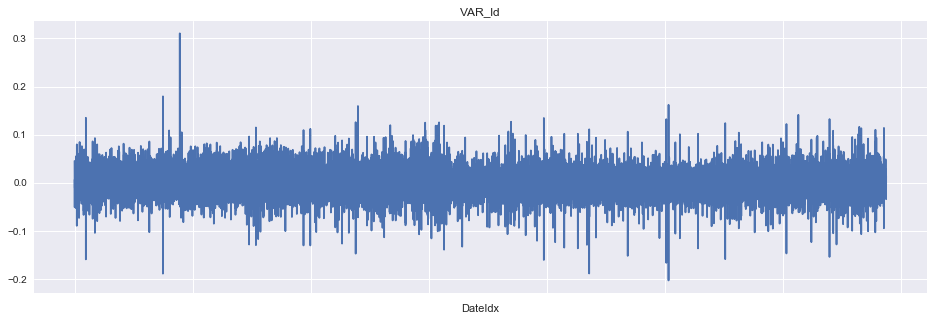

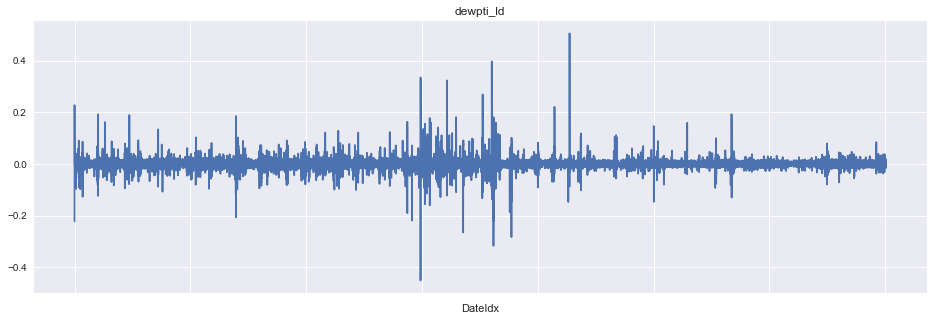

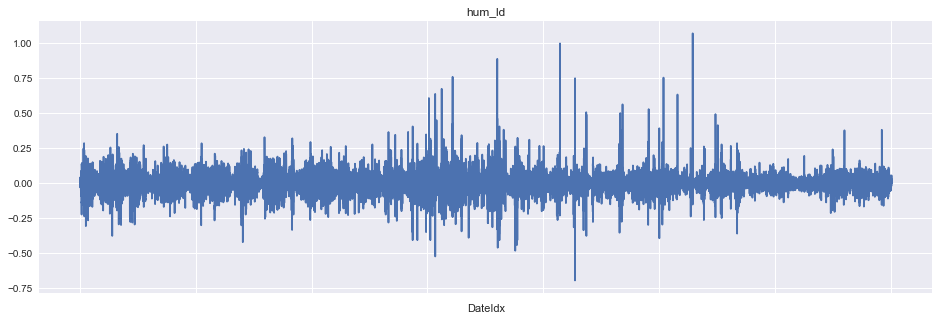

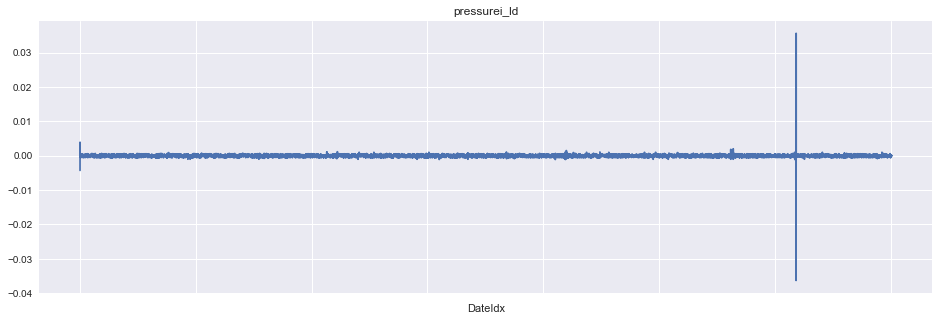

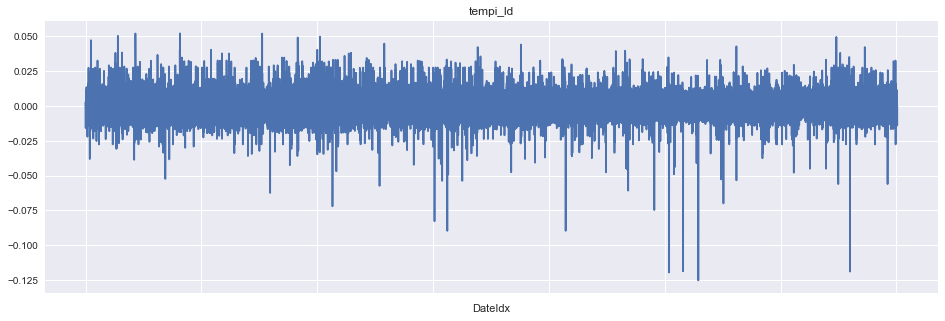

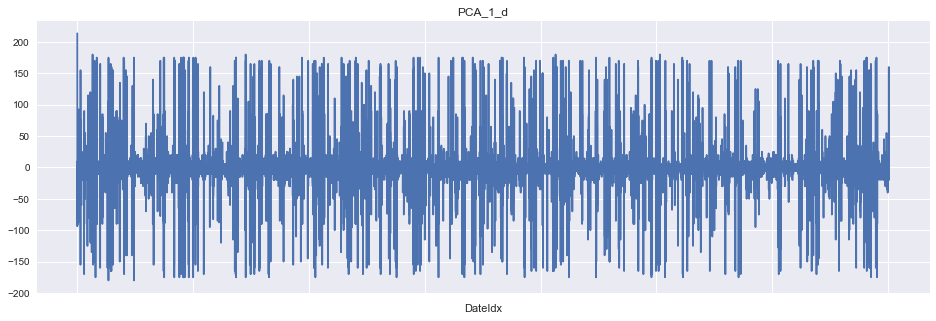

In [56]:
for col in ['VAR_ld', 'dewpti_ld', 'hum_ld', 'pressurei_ld', 'tempi_ld', 'PCA_1_d']:
    plt.figure(figsize=(16,5))
    df[col].plot(title=col)

Po transformacji wszystkie zmienne koncentrują się wokół zera ze względnie stałą wariancją - dla potrzeb naszej analizy uznamy je więc za procesy stacjonarne.

Ze względu na odwołanie naszych transformacji do przeszłych wartości, w naszym zestawie danych pojawiły się teraz wartości `NaN` tam gdzie przeszłych wartości brak - to jest na samym początku naszych szeregów czasowych:

In [57]:
df.iloc[:2,:]

,Date,VAR,dewpti,hum,pressurei,rain,tempi,thunder,Day,Holiday,...,Hour_22,Hour_23,VAR_lag,PCA_1_d,VAR_ld,VAR_lag_ld,dewpti_ld,hum_ld,pressurei_ld,tempi_ld
DateIdx,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,2016-05-01 00:00:00,24.25751,62.30,82.000000,29.960000,0.0,67.500000,0.0,1,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-01 00:15:00,2016-05-01 00:15:00,25.38191,49.85,84.458356,29.832557,0.0,67.257999,0.0,1,0,...,0,0,24.25751,213.586654,0.04531,NaN,-0.222943,0.029539,-0.004263,-0.003592


Pozbędziemy się więc tych obserwacji z dalszej analizy:

In [58]:
dset = df[pd.to_datetime(df.index) <= max_act].iloc[2:, :]
dset.shape, dset.dropna().shape

((34366, 66), (34366, 66))

In [59]:
test_set = df[pd.to_datetime(df.index) > max_act]
test_set.shape

(672, 66)

**Dobór zmiennych do modelu**

Na tym etapie jesteśmy gotowi wybrać z naszego zestawu danych zmienne do wykorzystania w procesie uczenia modelu. Dla ułatwienia dalszej pracy, uszeregujemy je w kategorie:
* zmienna zależna: `VAR_ld` - innymi słowy, będziemy modelowali wzrost logarytmowany zmiennej `VAR`
* zmienne binarne
* zmienne numeryczne
* zmienne transformowane do postaci wzrostu logarytmowanego

In [60]:
y_var = 'VAR_ld'

binary = ['Month_2', 'Month_3', 'Month_4', 'Month_5',
       'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
       'Month_12', 'Weekday_1', 'Weekday_2', 'Weekday_3',
       'Weekday_4', 'Weekday_5', 'Weekday_6', 'Hour_1', 'Hour_2', 
        'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6',
       'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
       'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
       'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'is_day', 'Holiday']

numerical = ['rain', 'thunder', 'PCA_1_d']

lds = ['dewpti_ld', 'hum_ld', 'pressurei_ld',
       'tempi_ld', 'VAR_lag_ld']

cols = lds + binary + numerical + [y_var]

Kolejny podział, który wprowadzimy w naszych danych - tym razem względem obserwacji a nie cech - to utworzenie następujących zestawów danych:
* **Zestaw treningowy** (***train***): dane, które wykorzystamy w procesie uczenia modelu
* **Zestaw walidacyjny** (***val***): dane, na których sprawdzać będziemy jakość prognozy *out-of-sample*. Skoro w naszych danych brakuje 672 ostatnich oberwacji zmiennej `VAR`, nasz zestaw walidacyjny również będzie miał taką wielkość. Ze względu na to, że mamy tu do czynienia z analizą szeregów czasowych, nasz zestaw walidacyjny nie powinien składać się z losowej próbki lecz z logicznej sekwencji - ustalimy więc, że będą to ostatnie dostępne 672 obserwacje, dla których mamy wartość zmiennej `VAR`
* **Zestaw testowy** (***test***): tak nazwiemy tę część obserwacji, dla której dokonamy ostatecznej prognozy, zgodnie z wymogami zadania

In [61]:
n_fcst = 672

train_set = dset[cols][:-n_fcst]
val_set = dset[cols][-n_fcst:]
test_set = test_set[cols]

train_X = train_set.drop(columns=y_var)
train_y = train_set[y_var]
val_X = val_set.drop(columns=y_var)
val_y = val_set[y_var]
test_X = test_set.drop(columns=y_var)

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape

((33694, 50), (33694,), (672, 50), (672,), (672, 50))

Aby ułatwić i przyspieszyć proces uczenia, dokonamy teraz [standaryzacji zmiennych niezależnych](https://pl.wikipedia.org/wiki/Standaryzacja_(statystyka)).

Aby uniknąć zjawiska tzw. "wycieku danych" (*data leakage*), nasze zestawy będą transformowane przy użyciu średnich i odchyleń standardowych wyliczonych z zestawu treningowego:

In [62]:
scaler = StandardScaler()

tr_X = scaler.fit_transform(train_X.astype('float64'))
v_X = scaler.transform(val_X.astype('float64'))
te_X = scaler.transform(test_X.astype('float64'))

tr_X.shape, v_X.shape, te_X.shape

((33694, 50), (672, 50), (672, 50))

**Transformacja do postaci okien prognozy**

Model klasy LSTM wymaga specyficznej struktury danych w procesie uczenia i wnioskowania. Analizuje on bowiem skończoną sekwencję danych (którą nazwiemy *oknem danych*) i na jej podstawie oblicza sekwencję prognoz (tę nazwiemy *oknem prognozy*).

Dotychczas nasz zestaw zmiennych niezależnych miał dwa wymiary - obserwacje x cechy - zaś zmienna zależna była wektorem przyjmowanej wartości dla każdej obserwacji. Po dokonaniu niezbędnych zmian zestawy te przybiorą one następujące wymiary:
- zmienne niezależne: obserwacje x okno danych x cechy
- zmienna zależna: obserwacje x okno prognozy

Po pierwsze musimy więc ustalić konkretne wartości dla okna danych i okna prognozy. Okno prognozy mamy w zasadzie określone w zasadach zadania - chcemy stworzyć model do prognozowania 96 obserwacji naprzód. 

Okno danych jest sprawą bardziej otwartą: chcielibyśmy aby było wystarczająco duże aby model mógł na jego podstawie wiarygodnie wyliczyć sekwencję dla całego dnia, ale odpowiednio małe aby proces uczenia nie trwał wiecznie i nie przeciążył procesora. Ustalimy więc wartość okna danych jako pełen tydzień poprzedzający okno prognozy: 672 obserwacji. Dzięki temu model nie powinien mieć problemów z wnioskowaniem w którym momencie cyklu tygodniowego i dziennego zaczyna się dana prognoza.

In [74]:
window = 672
f_window = 96

Ze względu na niemały rozmiar naszego zestawu treningowego, wprowadzenie dodatkowych wymiarów sprawi, że macierze na których operowałoby uczenie osiągną niebagatelne rozmiary (blisko miliard liczb!). Dlatego też dla potrzeb uczenia zdefiniujemy  generator, który dokonywał będzie odpowiednych transformacji na próbkach / pakietach (*batches*) danych aby oszczędzić cenny RAM. 

Model konstruować będziemy przy pomocy biblioteki `Keras`. Aby zapewnić kompatybilność z algorytmami `Keras`, generator będzie dziedziczył z klasy *Sequence*:

In [77]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, ind_vars, labels, window, f_window, batch_size=32, shuffle=True, validation=False):     
        super().__init__()
        self.batch_size = batch_size
        self.cols = ind_vars.shape[1]
        self.window = window
        self.f_window = f_window
        
        y_window = 0 if validation else window-1     
        self.labels = labels.values[y_window:]
        self.ind_vars = ind_vars[:-f_window+1]
        
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        '''
        Oblicza łączną liczbę pakietów (batch)
        '''
        return int(np.floor(len(self.ind_vars[window-1:]) / self.batch_size))

    def __getitem__(self, index):
        '''
        Generuje pojedynczy pakiet (batch)
        '''
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_X = np.zeros((self.batch_size, self.window, self.cols))
        batch_y = np.zeros((self.batch_size, self.f_window))
        
        for i in range(len(indexes)):
            idx = indexes[i]
            batch_X[i,:,:] = self.ind_vars[idx:idx+self.window]
            batch_y[i,:] = self.labels[idx:idx+self.f_window]

        return batch_X, batch_y

    def on_epoch_end(self):
        '''
        Losowe tasowanie indeksów po każdej epoce
        '''
        self.indexes = np.arange(len(self.ind_vars[window-1:]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

Czas na zdefiniowanie instancji klasy, które wykorzystamy do uczenia. W przypadku generatora danych walidacyjnych, powinniśmy uwzględnić fakt, że początkowo okno danych sięgać będzie jeszcze przed okres walidacji. Dokonamy więc małej modyfikacji w zestawie danych, na którym będziemy bazować ten generator:

In [78]:
v_X_t = np.concatenate((tr_X[-window+1:], v_X), axis=0)

Jednym z parametrów generatorów jest `batch_size` czyli rozmiar pakietów (tu: liczba okien danych + okien prognozy w pakiecie) jednorazowo przepuszczana przez sieć neuronową celem obliczenia gradientu i dokonania korekty w parametrach modelu. Ustalimy go na 32 sekwencje:

In [79]:
bs = 32
train_generator = DataGenerator(tr_X, train_y, window=window,
                                f_window=f_window, batch_size=bs, shuffle=True)
val_generator = DataGenerator(v_X_t, val_y, window=window, validation=True,
                                f_window=f_window, batch_size=bs, shuffle=False)
x, y = next(iter(val_generator))
x.shape, y.shape

((32, 672, 50), (32, 96))

Stworzymy też zestaw danych walidacyjnych, którego użyjemy przy ocenie skuteczności modelu w prognozie *out-of-sample*:

In [91]:
vg = DataGenerator(v_X_t, val_y, window=window, validation=True,
                                f_window=f_window, batch_size=(window - f_window + 1), shuffle=False)
v_X_w, v_y = next(iter(vg))
v_X_w.shape, v_y.shape

((577, 672, 50), (577, 96))

### Trenowanie modelu

Zanim zdefiniujemy samą postać funkcyjną modelu, stworzymy kilka narzędzi, które pomogą nam w procesie jego uczenia i walidacji.

**Funkcje pomocnicze**

W pierwszej kolejności fukncje pozwalające zapisać oraz wgrać strukturę i nauczone wagi modelu:

In [92]:
def save_model(model, name):
    '''
    Zapisanie struktury i nauczonych wag modelu
    '''
    now = datetime.now().strftime('%y-%m-%d-%H_%M')
    name = f'{name}_{now}'
    model_json = model.to_json()
    with open(f'models/{name}.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(f'models/{name}.h5')
    print(f'Model {name} zapisany')

In [93]:
def load_model(name):
    '''
    Wgranie struktury i nauczonych wag modelu
    '''
    with open(f'models/{name}.json', 'r') as json_file:
        model_json = json_file.read()
    lmodel = model_from_json(model_json)
    lmodel.load_weights(f'models/{name}.h5')
    print(f'Model {name} załadowany')
    return lmodel

Następnie kilka funkcji pozwalających na ocenę rezultatów procesu uczenia:

In [124]:
def training_plot(training, sz=(12,6)):
    '''
    Wykres kształtowania się matryk walidacyjnych w procesie uczenia modelu
    '''
    keys = [key for key in training.history.keys() if key[:4] != "val_"]
    for key in keys:
        try:
            plt.figure(figsize=sz)
            plt.title(key)
            plt.plot(training.history[key], label=f'Training {key}')
            plt.plot(training.history['val_' + key], label=f'Validation {key}')
            plt.legend()
        except:
            pass
    plt.show()

In [126]:
def ld_plot(model, x, y):
    '''
    Wykres prognozy dla wartości logarytmowanych wraz z wartościami metryk
    '''
    acts = y[0]
    preds = model.predict(x[0:1])[0]
    plt.figure(figsize=(12, 5))
    plt.plot(acts, label='Wartości rzeczywiste')
    plt.plot(preds, color='r', label='Prognoza')
    plt.legend()
    plt.show()
    print(f'R^2: {r2_score(acts, preds)*100:.2f}%')
    print(f'RMSE: {np.sqrt(mean_squared_error(acts, preds)):.4f}')
    print(f'MAE: {mean_absolute_error(acts, preds):.4f}')

In [96]:
def scale_back(preds, jump_off):
    '''
    Funkcja sprowadzająca prognozy wzrostu logarytmowanego do oryginalnych wartości
    
    jump_off -  wartość bazowa, od której będą wyliczane kolejne
                wartości w skali oryginalnej na podstawie sekwencji
                wzrostów logarytmowanych
    '''
    scaled_preds = np.zeros(preds.shape[0])
    for i in range(len(scaled_preds)):
        jump_off = np.exp(preds[i])*jump_off
        scaled_preds[i] = jump_off
    return scaled_preds

In [97]:
def random_plots(model, val_set, n=15):
    '''
    Wykresy obrazujące rzeczywiste i przewidywane wartości 
    zmiennej decyzyjnej w oryginalnej skali
    dla n losowych obserwacji zestawu walidacyjnego
    wraz z metrykami R^2, RMSE i MAE dla obserwacji oraz średnią dla n
    '''
    tot_r2 = []
    tot_rmse = []
    tot_mae = []
    idxs = np.random.permutation(range(len(val_set)))[:n]

    for i in idxs:
        # dane
        preds = model.predict(val_set[i:i+1])[0] 
        jump_off = df['VAR'][-(672*2)-1+i]
        scaled_acts = df['VAR'][-(672*2)+i:-(672*2)+i+f_window]
        scaled_preds = scale_back(preds, jump_off=jump_off)

        # metryki
        r2 = r2_score(scaled_acts, scaled_preds)
        rmse = np.sqrt(mean_squared_error(scaled_acts, scaled_preds))
        mae = mean_absolute_error(scaled_acts, scaled_preds)
        tot_r2.append(r2)
        tot_rmse.append(rmse)
        tot_mae.append(mae)
        print(f'{i+1}) R^2: {r2*100:.2f}%, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

        # wykresy
        plt.figure(figsize=(16,5))
        plt.title(f'Prognoza 24h od {df.index[-(672*2)-1+i]} vs wartości rzeczywiste')
        scaled_acts.plot(label='Wartości rzeczywiste')
        plt.plot(scaled_preds, color='r', label='Prognoza')
        plt.legend()
        plt.show()

    print("="*40)
    print(f'Średnie R^2: {np.mean(tot_r2)*100:.2f}%')
    print(f'Średnie RMSE: {np.mean(tot_rmse):.4f}')
    print(f'Średnie MAE: {np.mean(tot_mae):.4f}')

In [98]:
def fcst_7d(model, val_set):
    '''
    Rekursywny wykres prognozy 7-dniowej
    '''
    a7d = np.zeros(672)
    p7d = np.zeros(672)
    jump_off = df['VAR'][-(672*2)-1]
    vld = cols.index('VAR_lag_ld')

    for i in range(0, 577, f_window):
        for_prediction = (val_set[i:i+1])
        if i:
            for_prediction[0, -f_window:, vld] = preds      
        preds = model.predict(for_prediction)[0]       
        scaled_acts = df['VAR'][-(672*2)+i:-(672*2)+i+f_window]
        scaled_preds = scale_back(preds, jump_off=jump_off)
        a7d[i:i + f_window] = scaled_acts
        p7d[i:i + f_window] = scaled_preds
        jump_off = scaled_preds[-1]

    # wyniki:
    plt.figure(figsize=(16,5))
    plt.title('\nPrognoza - 7 dni\n')
    plt.plot(a7d, label='Wartości rzeczywiste')
    plt.plot(p7d, color='r', label='Prognoza')
    plt.legend()
    plt.show()
    print(f'R^2 siedmiodniowej prognozy: {r2_score(a7d, p7d)*100:.2f}%')
    print(f'RMSE siedmiodniowej prognozy: {np.sqrt(mean_squared_error(a7d, p7d)):.4f}')
    print(f'MAE siedmiodniowej prognozy: {mean_absolute_error(a7d, p7d):.4f}')

In [99]:
def val_scores(model, val_set):
    '''
    Średnie poziomy metryk R^2, RMSE i MAE dla całego zestawu walidacyjnego
    '''
    tot_r2 = []
    tot_rmse = []
    tot_mae = []

    for i in range(len(v_y)):
        preds = model.predict(val_set[i:i+1])[0]

        jump_off = df['VAR'][-(672*2)-1+i]
        scaled_acts = df['VAR'][-(672*2)+i:-(672*2)+i+f_window]
        scaled_preds = scale_back(preds, jump_off=jump_off)

        # metryki
        r2 = r2_score(scaled_acts, scaled_preds)
        rmse = np.sqrt(mean_squared_error(scaled_acts, scaled_preds))
        mae = mean_absolute_error(scaled_acts, scaled_preds)
        tot_r2.append(r2)
        tot_rmse.append(rmse)
        tot_mae.append(mae)
        
    print(f'Średnie R^2 w zestawie walidacyjnym: {np.mean(tot_r2)*100:.2f}%')
    print(f'Średnie RMSE w zestawie walidacyjnym: {np.mean(tot_rmse):.4f}')
    print(f'Średnie MAE w zestawie walidacyjnym: {np.mean(tot_mae):.4f}')

Zdefiniujemy też funkcję, która pozwoli nam określić istotność poszczególnych cech w procesie prognozowania przez zmierzenie zmian w średnim błędzie kwadratowym prognozy jakie wywoła losowe przetasowanie danej cechy:

In [118]:
def f_i(model, n_obs=672*2):
    '''
    Funkcja wyliczająca wkład poszczególnych cech na wynik funkcji straty modelu
    
    n_obs - rozmiar losowej próby, dla której dokonane zostaną obliczenia
    '''
    cols = train_set.columns[:-1]
    dg = DataGenerator(tr_X, train_y, window=window, f_window=f_window,
                       shuffle=True, batch_size=n_obs)
    sample_x, sample_y = next(iter(dg))
    sample_preds = model.predict(sample_x)
    sample_mse = mean_squared_error(sample_y, sample_preds)
    col_fi = []
    for i in range(sample_x.shape[-1]):
        col_x = sample_x.copy()
        np.random.shuffle(col_x[:,:,i])
        col_preds = model.predict(col_x)
        col_mse = mean_squared_error(sample_y, col_preds)
        col_fi.append(col_mse - sample_mse)

    # wizualizacja:
    fi = pd.DataFrame({'cols': cols, 'scores':col_fi}).set_index('cols').sort_values(by='scores', ascending=True)
    fi.plot.barh(figsize=(6,10), title='Wpływ poszczególnych zmiennych na MSE', xticks=[])
    plt.show()

Dostosowane metryki do wykorzystania w procesie uczenia modelu:

In [100]:
def rmse_(targ, preds): 
    return K.sqrt(K.mean(K.square(preds - targ)))

In [101]:
def r_sq_(targ, preds):
    SS_res =  K.sum(K.square(targ - preds)) 
    SS_tot = K.sum(K.square(targ - K.mean(targ))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

W procesie uczenia skorzystamy też z kilku dostosowanych funkcji typu *callback* - funkcji które mogą być wywołane w trakcie procesu uczenia modelu. Zdefiniujemy teraz instancje tych klas:

In [102]:
name = 'models/model_chp.hdf5'

# zatrzymanie procesu uczenia przy braku poprawy w funkcji straty mierzonej na koniec epoki w zestawie walidacyjnym:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

# zapisywanie wag modelu o najlepszym wyniku funkcji straty dla zestawu walidacyjnego:
mcp_save = ModelCheckpoint(name, save_best_only=True, monitor='val_loss', mode='min')

# obniżanie learning rate przy braku poprawy w funkcji straty mierzonej na koniec epoki w zestawie walidacyjnym:
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-6, mode='min')

**Model**

Czas zdefiniować samą architekturę. Użyjemy tu dwóch warstw komórek LSTM wyposażonych w *dropout* (technika regularyzacyjna polegająca na zerowaniu rezultatów losowego odsetka komórek) przedzielonych warstwą *batch normalisation* (odpowiedzialnej za standaryzację wyników z pierwszej warstwy względem pakietu - przyspiesza to proces uczenia). Ostateczna prognoza wygenerowana zostanie przez warstwę klasycznych neuronów (*Dense*).

In [104]:
model = Sequential()
model.add(LSTM(units=70, activation='tanh', return_sequences=True, input_shape=x[0].shape))
model.add(Dropout(rate=0.3))
model.add(BatchNormalization())
model.add(LSTM(units=70, activation='tanh', return_sequences=False))
model.add(Dropout(rate=0.3))
model.add(Dense(units=y.shape[1]))

In [107]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 672, 70)           33880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 672, 70)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 672, 70)           280       
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                39480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                6816      
Total params: 80,456
Trainable params: 80,316
Non-trainable params: 140
_________________________________________________________________


Do optymalizacji użyjemy popularnego w kontekście sieci LSTM algorytmu RMSProp:

In [105]:
optimiser = rmsprop(lr=1e-3)

Funkcją straty do optymalizacji będzie standardowy dla problemów regresyjnych średni błąd kwadratowy, do podglądu procesu uczenia wykorzystamy również R^2, RMSE i MAE:

In [106]:
model.compile(optimizer=optimiser,
              loss='mse',
              metrics=[r_sq_, rmse_, 'mae']
             )

Zgodnie ze wcześniejszą zapowiedzią, w procesie uczenia skorzystamy z naszych instancji generatorów oraz funkcji *callback*.

In [108]:
training = model.fit_generator(
    generator=train_generator, 
    epochs=10, 
    validation_data=val_generator, 
    callbacks=[
        earlyStopping,
        mcp_save,
        reduce_lr_loss
    ]
)

Epoch 1/10
1029/1029 [==============================] - 766s 745ms/step - loss: 0.0028 - r_sq_: -4.2989 - rmse_: 0.0354 - mean_absolute_error: 0.0270 - val_loss: 4.6896e-04 - val_r_sq_: 0.2103 - val_rmse_: 0.0213 - val_mean_absolute_error: 0.0160
Epoch 2/10
1029/1029 [==============================] - 793s 771ms/step - loss: 4.0923e-04 - r_sq_: 0.2361 - rmse_: 0.0202 - mean_absolute_error: 0.0146 - val_loss: 4.5973e-04 - val_r_sq_: 0.2279 - val_rmse_: 0.0211 - val_mean_absolute_error: 0.0158
Epoch 3/10
1029/1029 [==============================] - 777s 755ms/step - loss: 3.9684e-04 - r_sq_: 0.2593 - rmse_: 0.0199 - mean_absolute_error: 0.0143 - val_loss: 4.5526e-04 - val_r_sq_: 0.2362 - val_rmse_: 0.0210 - val_mean_absolute_error: 0.0157
Epoch 4/10
1029/1029 [==============================] - 758s 737ms/step - loss: 3.8880e-04 - r_sq_: 0.2743 - rmse_: 0.0197 - mean_absolute_error: 0.0141 - val_loss: 4.4919e-04 - val_r_sq_: 0.2471 - val_rmse_: 0.0208 - val_mean_absolute_error: 0.0156
Epo

W ostatnich dwóch epokach uczenia widzimy pogorszenie wartości MSE dla zestawu walidacyjnego. Skorzystamy więc z wag modelu zapisanego przez nasz *callback* pod koniec epoki 8.:

In [109]:
model.load_weights(name)

Zapisujemy też końcową postać modelu:

In [110]:
save_model(model, 'model_final')

Model model_final_19-02-05-19_47 zapisany


Możemy też przejrzeć wykresy metryk decyzyjnych zapisywanych po każdej epoce:

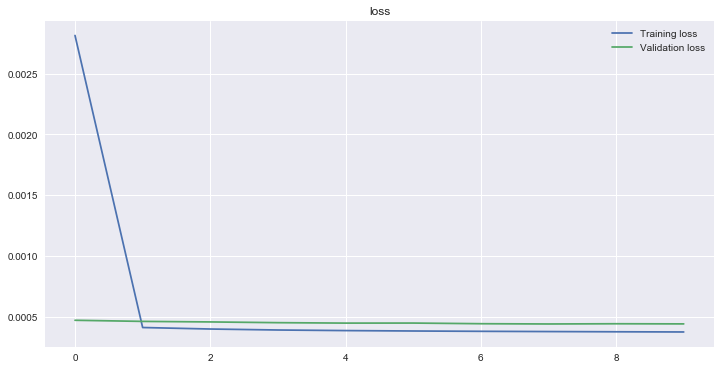

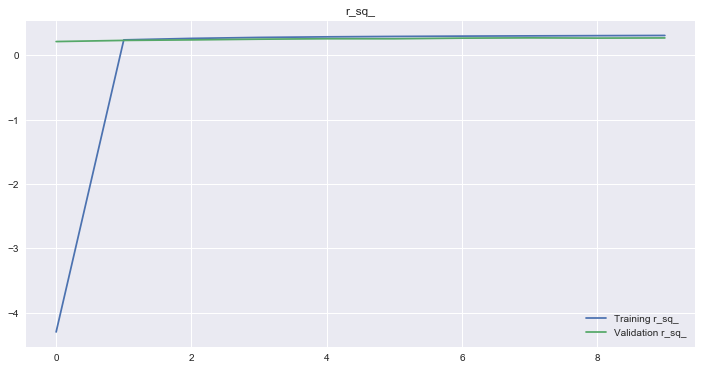

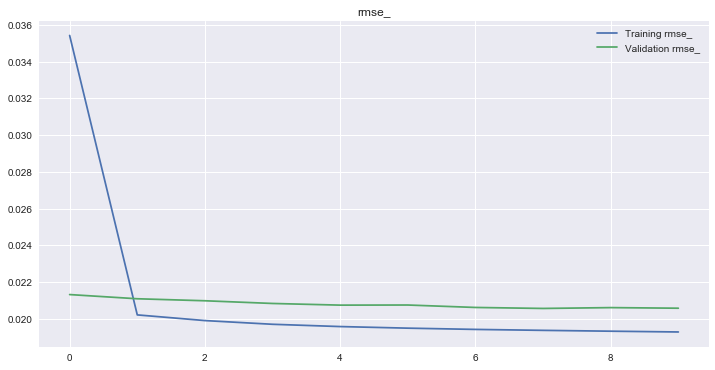

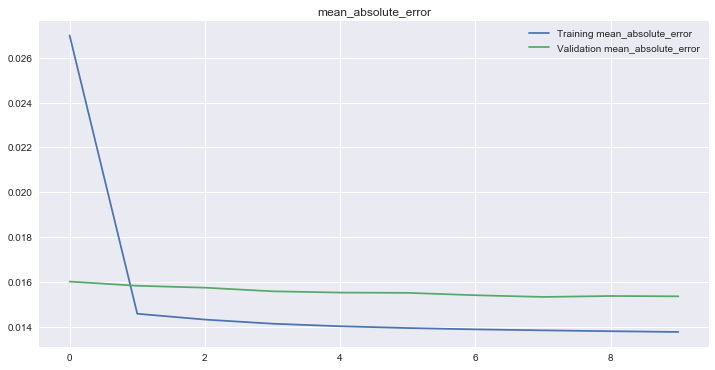

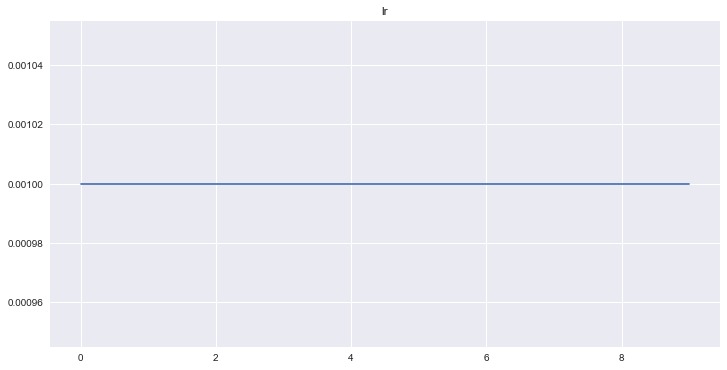

In [125]:
training_plot(training)

**Ocena jakości prognoz modelu**

Czas zobaczyć jak działa nasz model w praktyce. 

W pierwszej kolejności spójrzmy jak radzi sobie z pojedynczą obserwacją z zestawu treningowego:

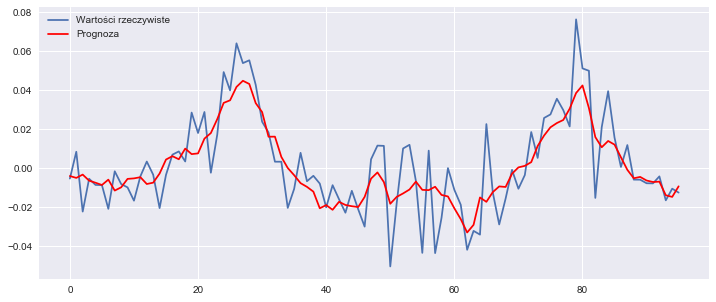

R^2: 67.76%
RMSE: 0.0139
MAE: 0.0105


In [127]:
x, y = next(iter(train_generator))
ld_plot(model, x, y)

Wydaje się, że model całkiem skutecznie złapał sygnał - potwierdza to dość wysokie R^2. 

Sprawdźmy skuteczność w przypadku pojedynczej obserwacji z zestawu walidacyjnego:

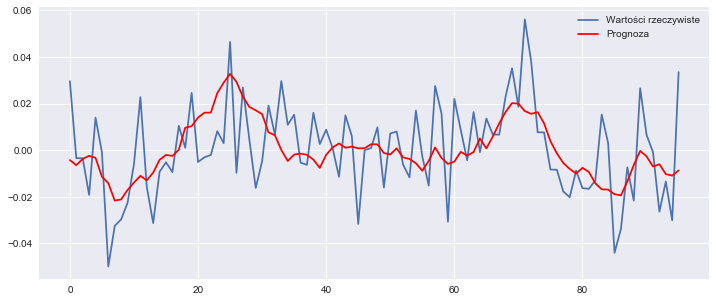

R^2: 23.24%
RMSE: 0.0170
MAE: 0.0136


In [128]:
x, y = next(iter(val_generator))
ld_plot(model, x, y)

Tu wynik R^2 jest bliżej osiągów, które widzieliśmy w procesie uczenia. Należy jednak pamiętać, że ze względu na transformację do postaci stacjonarnej, której dokonaliśmy, wzmocniliśmy też szum w modelowanych danych. W związku z tym niezbyt wysokie wartości dopasowania R^2 są nie tylko spodziewane, ale w jakimś stopniu również oczekiwane - w przeciwnym razie istniałoby ryzyko, że modelujemy szum czyli pojawiłby się temat *overfitting*... 

Istotne dla nas jest natomiast jak model radzi sobie na poziomie oryginalnych wartości przyjmowanych przez `VAR`. Przy pomocy zdefiniowanych wcześniej funkcji sprowadzimy więc naszą prognozę do tej postaci i przejrzymy wykresy dla losowej próbki obserwacji z zestawu walidacyjnego:

513) R^2: 71.00%, RMSE: 1.0822, MAE: 0.8571


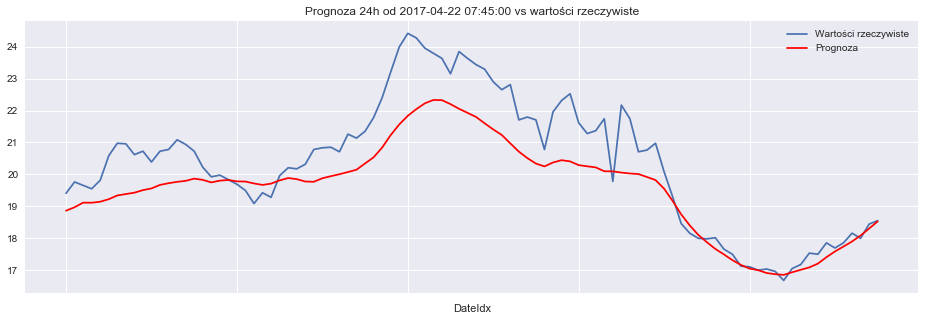

70) R^2: 63.93%, RMSE: 1.3619, MAE: 1.0585


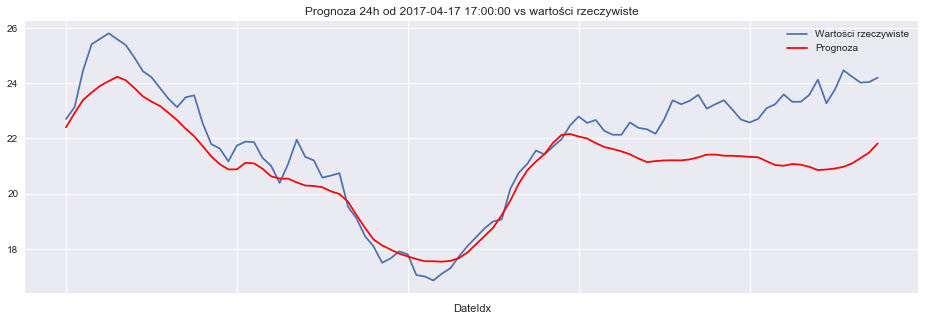

531) R^2: 70.96%, RMSE: 1.1202, MAE: 0.9628


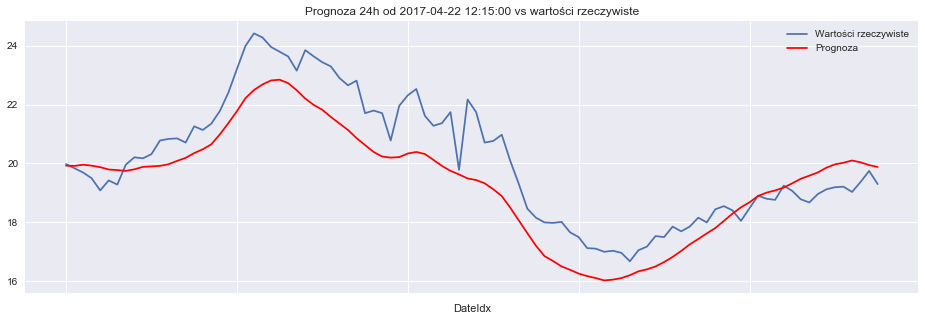

203) R^2: 79.65%, RMSE: 1.1345, MAE: 0.9316


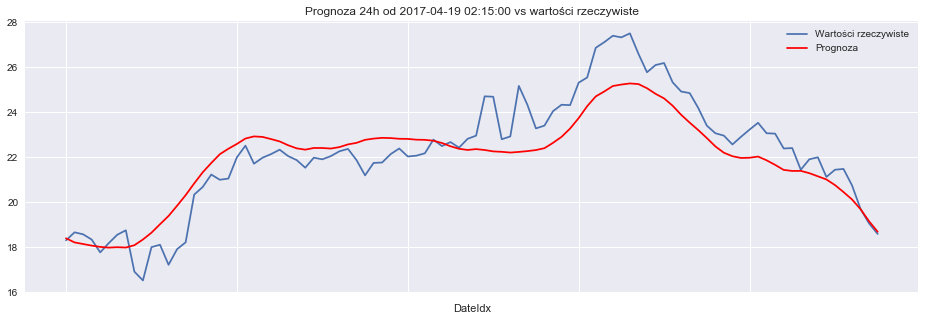

439) R^2: 61.75%, RMSE: 1.6535, MAE: 1.3594


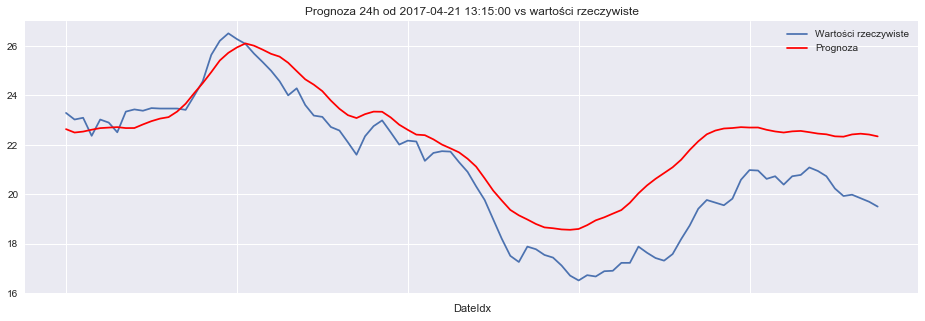

284) R^2: 32.20%, RMSE: 1.8698, MAE: 1.5997


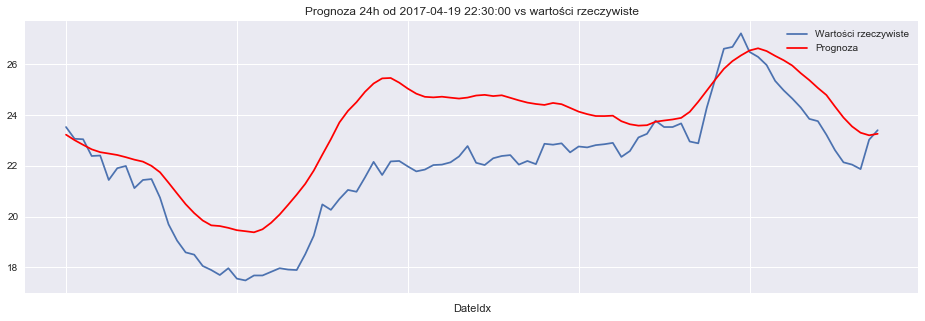

185) R^2: 80.61%, RMSE: 1.1042, MAE: 0.8556


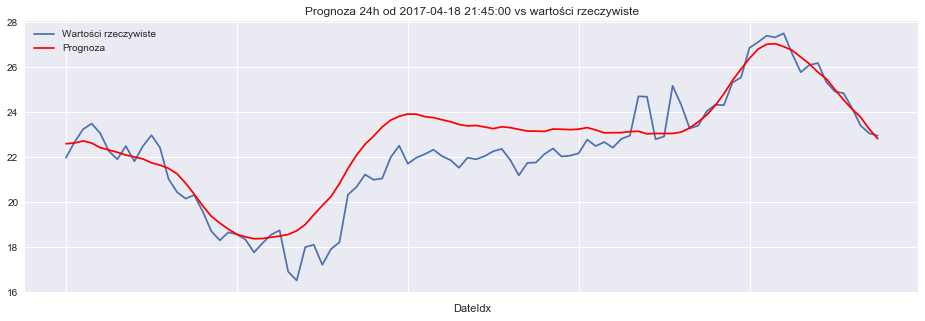

496) R^2: 82.02%, RMSE: 0.8764, MAE: 0.7350


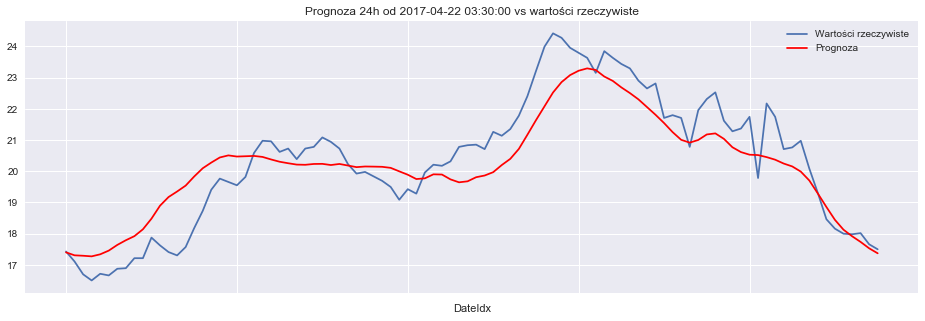

396) R^2: 72.86%, RMSE: 1.1446, MAE: 0.8658


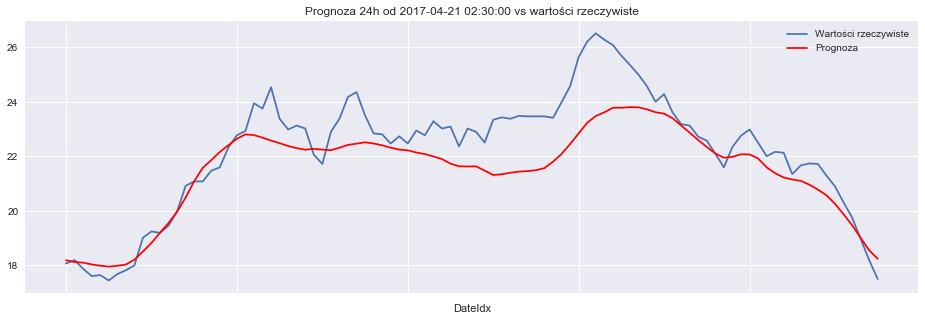

268) R^2: 59.66%, RMSE: 1.5380, MAE: 1.3126


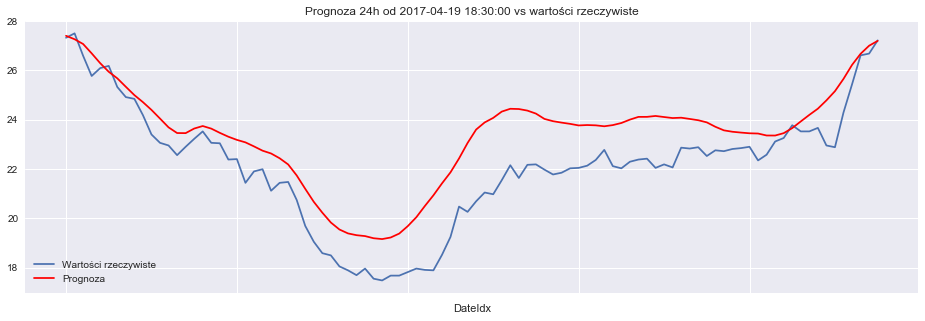

536) R^2: 47.60%, RMSE: 1.5132, MAE: 1.2525


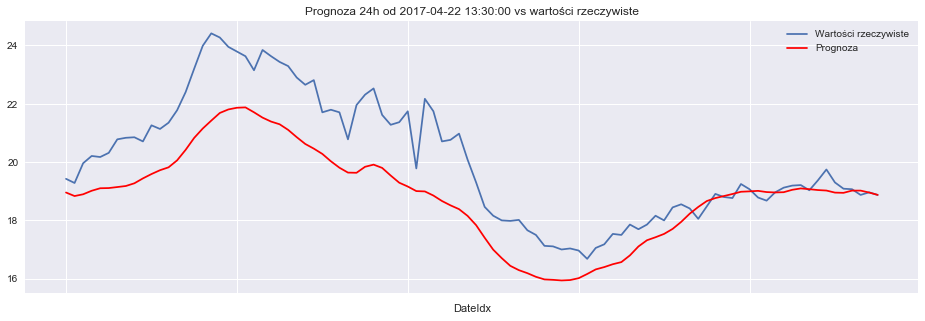

102) R^2: 38.98%, RMSE: 2.1426, MAE: 1.8752


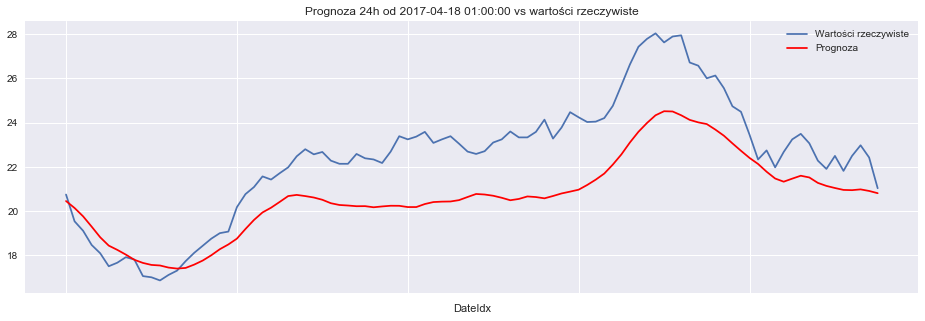

566) R^2: 50.51%, RMSE: 1.3393, MAE: 1.2203


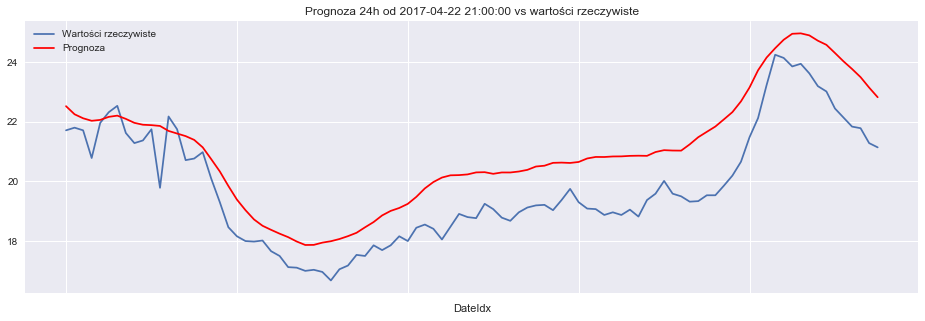

189) R^2: 51.24%, RMSE: 1.7518, MAE: 1.4531


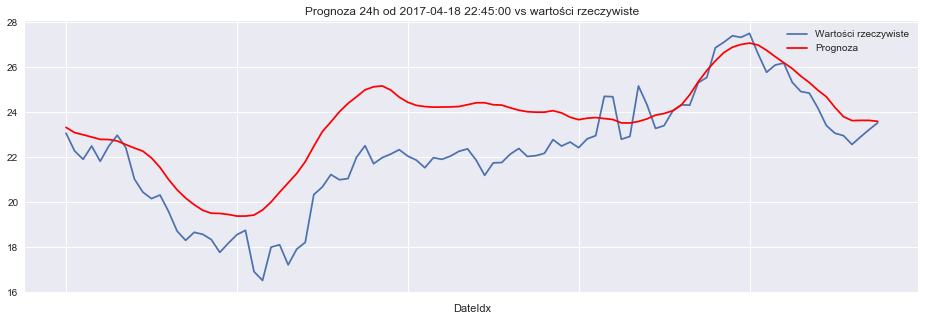

46) R^2: 66.25%, RMSE: 1.2281, MAE: 1.0287


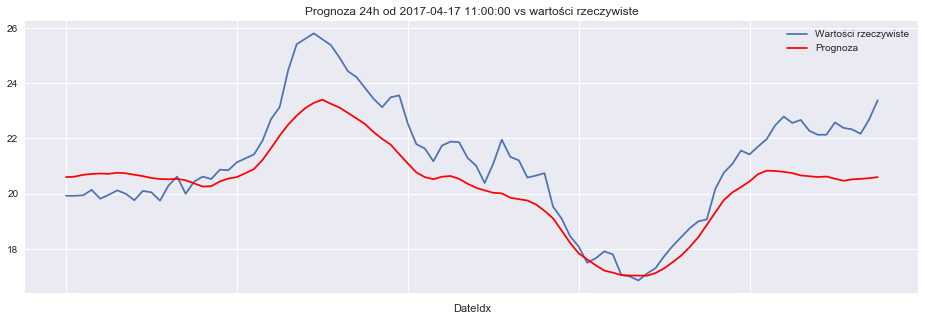

Średnie R^2: 61.95%
Średnie RMSE: 1.3907
Średnie MAE: 1.1579


In [114]:
random_plots(model, v_X_w)

W naszej losowej próbce obserwujemy relatywnie wysoką skuteczność modelu - średnio ponad 60% R^2, zaś średni błąd kwadratowy nie przekracza 1.3 - przy średnim `VAR` na poziomie 25 wydaje się to być dobrym osiągnięciem!

Dla pełni obrazu obliczymy średnie statystyki dla całego zestawu walidacyjnego:

In [115]:
val_scores(model, v_X_w)

Średnie R^2 w zestawie walidacyjnym: 67.82%
Średnie RMSE w zestawie walidacyjnym: 1.2723
Średnie MAE w zestawie walidacyjnym: 1.0593


Jest nawet lepiej niż w naszej próbie losowej - wygląda na to, że model dobrze radzi sobie z prognozowaniem 96 obserwacji naprzód!

Sprawdźmy więc co się stanie przy prognozie rekursywnej dla całego tygodnia w naszym zestawie walidacyjnym:

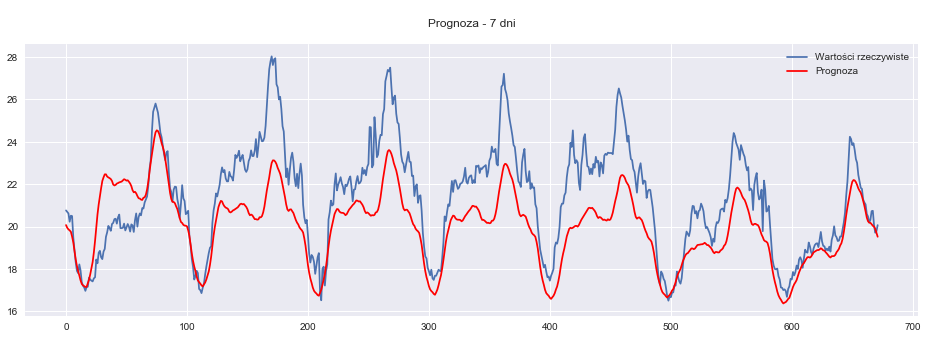

R^2 siedmiodniowej prognozy: 39.41%
RMSE siedmiodniowej prognozy: 1.9441
MAE siedmiodniowej prognozy: 1.6058


In [116]:
fcst_7d(model, v_X_w)

Skuteczność jest wyraźnie niższa, ale wciąż na względnie akceptowalnym poziomie. Warto zwrócić uwagę na relatywie wysoką skuteczność prognozy w przypadku dwóch ostatnich dni - dni weekendowych.

Z analizy danych i wyników modelu możemy się domyślać, które zmienne użyte w modelu okażą się najistotniejsze, ale sprawdźmy to teraz empirycznie:

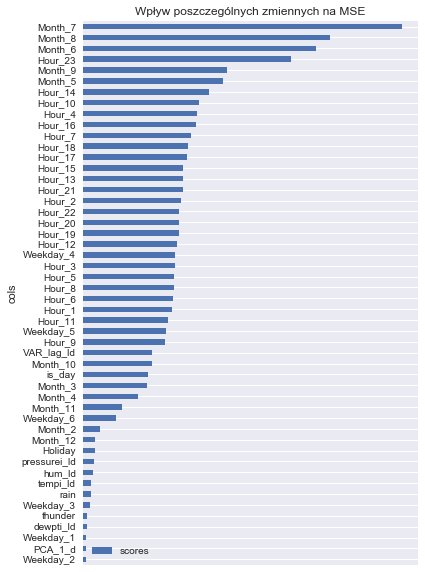

In [119]:
f_i(model)

Zgodnie z podejrzeniami, zdecydowanie najważniejsze okazały się cechy związane z datą / sezonowością. Z cech oryginalnie dostarczonych najwyżej plasuje się `is_day` - co również nie dziwi w świetle naszych wcześniejszych ustaleń. 

Cechy związane z pogodą natomiast wydają się mieć niewielki wpływ na prognozę. Może to wynikać w jakimś stopniu z faktu, że do prognozy używamy jedynie przeszłych wartości - model jest więc "ślepy" na odchylenia pogodowe występujące w samym oknie prognozy i mocniej polega na dających się klarownie przewidzieć wartościach zmiennych sezonowych.

**Możliwe dalsze usprawnienia**

Pomimo uzyskania całkiem zadowalających rezultatów przy naszym obecnym podejściu, możliwe są pewne kierunki dalszego rozwoju, które mogłyby potencjalnie podnieść skuteczność prognozy:

* **wykorzystanie *embeddings*** - obecnie zmienne kategoryczne są reprezentowane w naszym zestawie danych jako wektory *one-hot*. Reprezentowanie ich w postaci wektorów *embeddings* pozwoliłoby zredukować rozmiar danych wsadowych, przede wszystkim jednak mogłoby zwiększyć skuteczność ujawniania nieliniowych i złożonych zależności tych zmiennych względem prognozowanej zmiennej i pozostałych zmiennych
* **wykorzystanie "przyszłych" wartości zmiennych pogodowych** - obecnie model opiera swoje wnioskowanie na temat przyszłych wartości w pełni na wartościach przeszłych. Skoro mamy jednak dostępne "prognozy" zmiennych niezależnych również dla 96 obserwacji w naszym oknie prognozy, można by je również włączyć do estymacji
* **rozszerzenie okna prognozy** - wspierając się odpowiednio potężną mocą obliczeniową, można by rozszerzyć okno danych i okno prognozy aby uwzględnić bardziej długoterminowe zależności - np. pokusić się o prognozę całego tygodnia naprzód ma bazie ostatniego miesiąca, itp.

## Eksport wyników modelu

W ostatnim kroku naszej analizy wygenerujemy prognozę całodobową dla 2017-04-24 i zobrazujemy ją kilkoma wykresami aby upewnić się, że wyniki wyglądają rozsądnie:

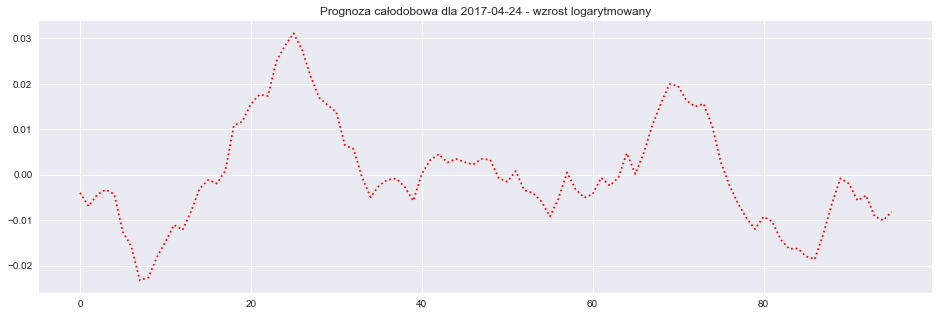

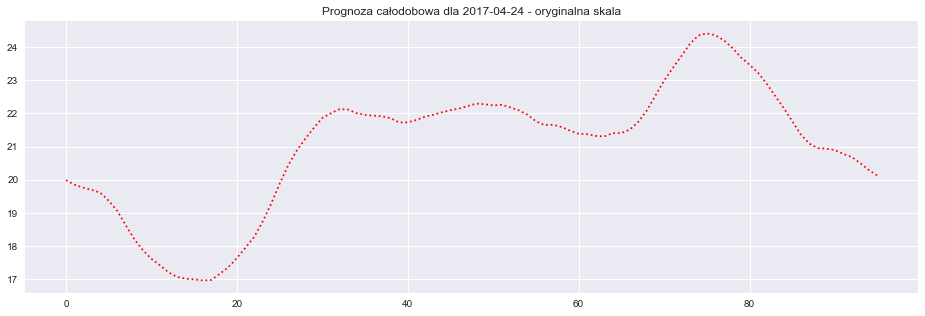

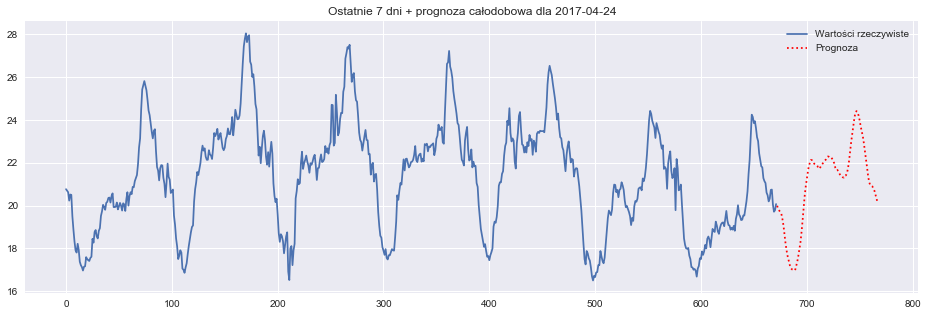

In [120]:
# prognoza:
test_preds = model.predict(np.concatenate((v_X[-window+1:], te_X[0:1]))[None,:])[0]
jump_off = df['VAR'].dropna()[-1]
scaled_test_preds = scale_back(test_preds, jump_off=jump_off)
dt = test_set[0:1].index[0][:10]

# wykresy:
plt.figure(figsize=(16, 5))
plt.title(f'Prognoza całodobowa dla {dt} - wzrost logarytmowany')
plt.plot(test_preds, color='r', linestyle=':')
plt.figure(figsize=(16, 5))
plt.title(f'Prognoza całodobowa dla {dt} - oryginalna skala')
plt.plot(scaled_test_preds, color='r', linestyle=':')
plt.show()
plt.figure(figsize=(16, 5))
plt.title(f'Ostatnie 7 dni + prognoza całodobowa dla {dt}')
plt.plot(np.concatenate((df['VAR'].dropna()[-window:].values, [np.nan]*f_window)), label='Wartości rzeczywiste')
plt.plot(np.concatenate(([np.nan]*window, scaled_test_preds)), color='r', linestyle=':', label='Prognoza')
plt.legend()
plt.show()

Prognoza nie budzi szczególnych zastrzeżeń, w szczególności w kontekście ostatnich dni wartości rzeczywistych. W związku z tym zapiszemy wyniki w formacie .csv:

In [136]:
edf = pd.DataFrame({'Date': test_set.index[:f_window], 'VAR': scaled_test_preds}).set_index('Date', drop=True)
edf.head()

,VAR
Date,
2017-04-24 00:00:00,19.938633
2017-04-24 00:15:00,19.778852
2017-04-24 00:30:00,19.714011
2017-04-24 00:45:00,19.684499
2017-04-24 01:00:00,19.611913


In [137]:
edf.to_csv(f'prognoza_calodobowa_dla_{dt}.csv')

**Bonus**

Zachęceni nienajgorszą skutecznością rekursywnej prognozy siedmiodniowej w zestawie walidacyjnym, wygenerujemy podobną prognozę dla zestawu testowego:

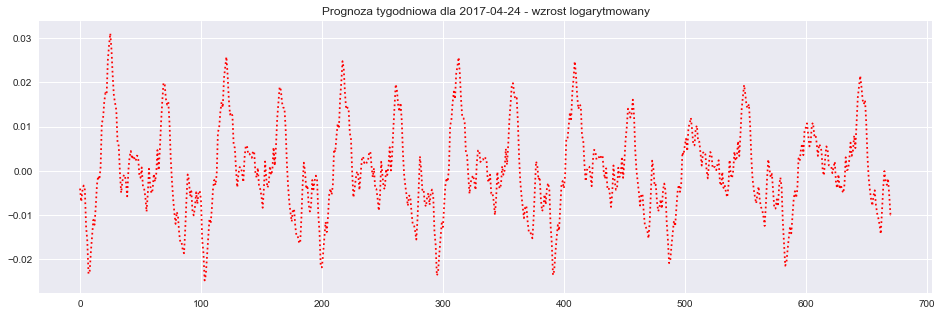

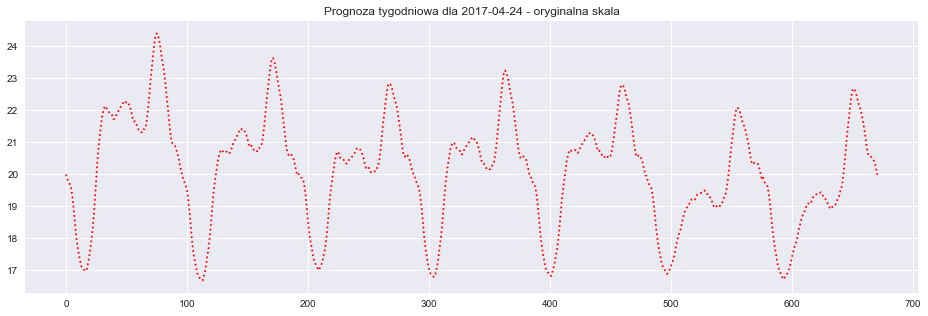

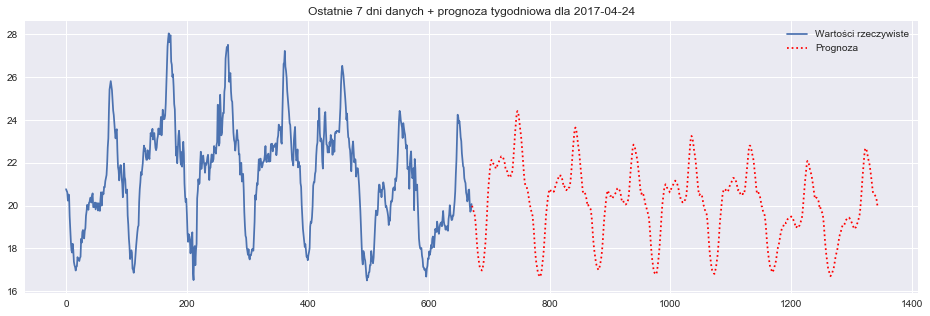

In [123]:
# prognoza:
fcst_data = np.concatenate((v_X[-window+1:], te_X))

# wartości startowe:
jump_off = df['VAR'].dropna()[-1]
dt = test_set[0:1].index[0][:10]
vdl = cols.index('VAR_lag_ld')
results_ld = np.zeros(window)
results_sc = np.zeros(window)

for i in range(7):
    fcst_w = fcst_data[i*f_window:i*f_window+window]
    if i:
        fcst_w[-f_window:, vdl] = test_preds
    test_preds = model.predict(fcst_w[None,:])[0]
    scaled_test_preds = scale_back(test_preds, jump_off=jump_off)
    results_ld[i*f_window:(i+1)*f_window] = test_preds
    results_sc[i*f_window:(i+1)*f_window] = scaled_test_preds



# wykresy:
plt.figure(figsize=(16, 5))
plt.title(f'Prognoza tygodniowa dla {dt} - wzrost logarytmowany')
plt.plot(results_ld, color='r', linestyle=':')
plt.figure(figsize=(16, 5))
plt.title(f'Prognoza tygodniowa dla {dt} - oryginalna skala')
plt.plot(results_sc, color='r', linestyle=':')
plt.show()
plt.figure(figsize=(16, 5))
plt.title(f'Ostatnie 7 dni danych + prognoza tygodniowa dla {dt}')
plt.plot(np.concatenate((df['VAR'].dropna()[-window:].values, [np.nan]*window)), label='Wartości rzeczywiste')
plt.plot(np.concatenate(([np.nan]*window, results_sc)), color='r', linestyle=':', label='Prognoza')
plt.legend()
plt.show()

Wydaje się, że nasza rekursywna prognoza przejawia delikatną tendencję spadkową, której zaczej nie spodziewamy się w danych. Ponownie widać natomiast, że wartości dla dni weekendowych kształtują się w prognozie inaczej niż dni powszednie - podobnie jak w danych rzeczywistych. 

Tak czy inaczej, te wyniki również zapiszemy w formacie .csv:

In [138]:
edf2 = pd.DataFrame({'Date': test_set.index, 'VAR': results_sc}).set_index('Date', drop=True)
edf2.head()

,VAR
Date,
2017-04-24 00:00:00,19.987210
2017-04-24 00:15:00,19.848932
2017-04-24 00:30:00,19.761301
2017-04-24 00:45:00,19.696015
2017-04-24 01:00:00,19.611528


In [139]:
edf2.to_csv(f'prognoza_calotygodniowa_dla_{dt}.csv')